## The analysis of the inflation data

In this notebook we investigate the dynamics of inflation over the last years. The records are queried from the <a href='inflation_database.db'>`inflation_database.db`</a> database, where the cleaned data are stored (see the <a href="0-data_cleaning.ipynb">0-data_cleaning.ipynb</a> notebook for details on collecting and cleaning the original datasets).

In [1]:
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The inflation tables in the <a href='inflation_database.db'>`inflation_database.db`</a> file are given in two timescales: monthly (the `inflation_monthly` table) and quarterly (the `inflation_quarterly` table). Hence, after querying, we transform the **date** columns into `pd.Period` objects for clarity.

In [2]:
with sqlite3.connect('inflation_database.db') as connection:
    infl_m = pd.read_sql('SELECT * FROM inflation_monthly', connection, 
                index_col = 'date', parse_dates='date').to_period('M')
    infl_q = pd.read_sql('SELECT * FROM inflation_quarterly', connection, 
                index_col = 'date', parse_dates='date').to_period('Q')

### The monthly inflation <a id='monthly_infl'></a>

At first we will focus on the monthly inflation dataset, which sample is given below:

In [3]:
infl_m.sample(5, random_state=0)

,household,good,inflation
date,,,
2021-07,Households of farmers,Operation of personal transport equipment,103.3
2019-09,Households of retirees,COMMUNICATIONS,99.3
2022-04,Households of employees,FOOD AND NON-ALCOHOLIC BEVERAGES,104.1
2022-01,Households of farmers,MISCELLANEOUS GOODS AND SERVICES,101.9
2014-11,Households of employees,Footwear,100.0


The data frame contains the values of price indices (the **inflation** column), participated into different types of households and goods/services (the latter ones include also the main categories denoted by capital letters, as shown above). Within each column, we have also the <font color=#ff7f0e>GRAND TOTAL</font> group, that includes the aggregated results across all households or goods. More details on the structure of the considered data frame can be found in the <a href="0-data_cleaning.ipynb">0-data_cleaning.ipynb</a> notebook.

The monthly scale determines how the price level changed within the last month. For example, in the first row shown above we can see, that the price of <font color=#ff7f0e>operation of personal transport equipment</font> among the <font color=#ff7f0e>households of farmers</font> was higher by 3.3% in July 2021, than in June 2021. The percentage index is calculated on the basis of a typical basket of goods and services for chosen household, so the values between the latter ones can differ.

**Note**: Formally, the *inflation* term describes the phenomenon of the increases in price levels (as opposed to *deflation*, when the prices decrease). The **inflation** column in our data frame describes the change of price level within particular time interval, regardless its growth or decline.

We will transform the data to collect the inflation on three different time scales, i.e.:
* monthly (already present) - the **inflation_m2m** column,
* yearly (the change of price in the current month in relation to the price from the same month one year ago) - the **inflation_y2y** column, and
* cumulatively (the change of price in the current month in relation to the price from December 2009; the first available record is given for January 2010) - the **inflation_cumul** column.

We have to calculate the indicators separately for each category (grouping by **household** and **good**), ensuring that the dates are sorted in the proper order for window calculations. We will express the final values as percentage change (positive - increase, negative - decrease) to make the data more intuitive.

In [4]:
infl_m = infl_m.sort_index().assign(
    inf_rate=lambda x: x.inflation / 100.0,  # for calculations clarity only
    inflation=lambda x: x.inflation - 100.0, 
    inflation_y2y=lambda x: x.groupby(['household', 'good'])\
        .inf_rate.transform(lambda y: y.rolling(12, min_periods=12)\
        .agg(np.product)) * 100.0 - 100.0, 
    inflation_cumul=lambda x: x.groupby(['household', 'good'])\
        .inf_rate.cumprod() * 100.0 - 100.0
).drop('inf_rate', axis=1).rename(columns={'inflation': 'inflation_m2m'})

infl_m[(infl_m.household == 'GRAND TOTAL') & 
       (infl_m.good == 'GRAND TOTAL')].loc['2022']

,household,good,inflation_m2m,inflation_y2y,inflation_cumul
date,,,,,
2022-01,GRAND TOTAL,GRAND TOTAL,1.9,9.366666,33.859315
2022-02,GRAND TOTAL,GRAND TOTAL,-0.3,8.496086,33.457737
2022-03,GRAND TOTAL,GRAND TOTAL,3.3,10.966789,37.861842
2022-04,GRAND TOTAL,GRAND TOTAL,2.0,12.287822,40.619079
2022-05,GRAND TOTAL,GRAND TOTAL,1.7,13.855150,43.009604
2022-06,GRAND TOTAL,GRAND TOTAL,1.5,15.447529,45.154748
2022-07,GRAND TOTAL,GRAND TOTAL,0.5,15.562517,45.880521
2022-08,GRAND TOTAL,GRAND TOTAL,0.8,16.138601,47.047565
2022-09,GRAND TOTAL,GRAND TOTAL,1.6,17.176583,49.400327


The frame included above shows how the inflation changed in 2022, across all goods and households (the <font color=#ff7f0e>GRAND TOTAL</font> category); e.g., the prices in January 2022 were 9.37% higher than in January 2021 (see the **inflation_y2y** column).

We can change the `pandas` display resolution to two decimal points for clarity. We will also split the goods into the group including only the main categories (denoted by upper case) and the remaining ones.

In [5]:
pd.options.display.float_format = lambda x: '%.2f' % x

goods_main = [good for good in infl_m.good.unique() if good == good.upper()]

goods_n_main = [good for good in infl_m.good.unique()
    if good not in goods_main] + ['GRAND TOTAL']  # include for comparison only

Let's investigate the total inflation first (regardless the household), focusing on the main categories of goods.

In [6]:
infl_tot = infl_m.query('household == "GRAND TOTAL" '
                        f'and good.isin({goods_main})')\
    .drop(columns='household').pivot(columns='good')
                        
infl_tot.head(3)

inflation_m2m                                       \
good    ALCOHOLIC BEVERAGES AND TOBACCO CLOTHING AND FOOTWEAR COMMUNICATIONS   
date                                                                           
2010-01                            0.10                 -2.30           0.60   
2010-02                            0.60                 -1.60          -0.40   
2010-03                            1.30                  0.60          -0.20   

                                                    \
good    EDUCATION FOOD AND NON-ALCOHOLIC BEVERAGES   
date                                                 
2010-01      0.20                             0.90   
2010-02      0.00                             0.30   
2010-03      0.10                             0.30   

                                                                               \
good    FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE MAINTENANCE OF THE HOUSE   
date                                                                            
2010-01                                               0.00                      
2010-02                                               0.10                      
2010-03                                               0.10                      

                                                                             \
good    GRAND TOTAL HEALTH HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS   
date                                                                          
2010-01        0.60   0.50                                             1.10   
2010-02        0.20   0.30                                             0.90   
2010-03        0.30   0.20                                             0.10   

                                          ... inflation_cumul  \
good    MISCELLANEOUS GOODS AND SERVICES  ...       EDUCATION   
date                                      ...                   
2010-01                             0.10  ...            0.20   
2010-02                             0.20  ...            0.20   
2010-03                             0.20  ...            0.30   

                                          \
good    FOOD AND NON-ALCOHOLIC BEVERAGES   
date                                       
2010-01                             0.90   
2010-02                             1.20   
2010-03                             1.51   

                                                                               \
good    FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE MAINTENANCE OF THE HOUSE   
date                                                                            
2010-01                                               0.00                      
2010-02                                               0.10                      
2010-03                                               0.20                      

                                                                             \
good    GRAND TOTAL HEALTH HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS   
date                                                                          
2010-01        0.60   0.50                                             1.10   
2010-02        0.80   0.80                                             2.01   
2010-03        1.10   1.00                                             2.11   

                                                                 \
good    MISCELLANEOUS GOODS AND SERVICES RECREATION AND CULTURE   
date                                                              
2010-01                             0.10                   1.30   
2010-02                             0.30                   0.69   
2010-03                             0.50                   0.29   

                                          
good    RESTAURANTS AND HOTELS TRANSPORT  
date                                      
2010-01                   0.30      1.10  
2010-02                   0.60      1.61  
2010-03               

We can determine how the cumulative inflation changed in the whole time interval (the prices in March 2023 vs. the prices in December 2009), including the comparison with the <font color=#ff7f0e>GRAND TOTAL</font> growth (see the **ratio_GT** column):

In [7]:
# the grand total cumulative change
infl_tot_GT = infl_tot['inflation_cumul'].loc['2023-03', 'GRAND TOTAL']

# final cumulative changes for the goods
infl_tot_last = infl_tot['inflation_cumul'].loc['2023-03']\
    .sort_values(ascending=False).to_frame('cumul_2023_03')\
    .assign(ratio_GT=lambda x: x / infl_tot_GT)

infl_tot_last

,cumul_2023_03,ratio_GT
good,,
"HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS",104.65,1.72
RESTAURANTS AND HOTELS,85.79,1.41
FOOD AND NON-ALCOHOLIC BEVERAGES,81.65,1.34
GRAND TOTAL,60.77,1.00
ALCOHOLIC BEVERAGES AND TOBACCO,58.08,0.96
HEALTH,50.28,0.83
EDUCATION,50.27,0.83
RECREATION AND CULTURE,46.21,0.76
TRANSPORT,43.15,0.71


The prices increased on average by 60.77%, with the largest increase in <font color=#ff7f0e>HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS</font> by 104.65% (which is almost 3/4 higher than the average, grand total increase). The <font color=#ff7f0e>FOOD AND NON-ALCOHOLIC BEVERAGES</font> noted 81.65% growth in prices (1/3 above the average). On the other hand, many of the categories are below the grand total level, with the smallest increase in <font color=#ff7f0e>COMMUNICATIONS</font> by only 11.77% (1/5 of the total increase). Only the prices of <font color=#ff7f0e>CLOTHING AND FOOTWEAR</font> decreased, becoming 27.58% cheaper than in December 2009.

To investigate the dynamics of inflation, we can visualize the changes in the cumulative index within the available time frame. We will focus on the top four rows from the data frame above, which include the grand total change of prices and three categories with the higher score.

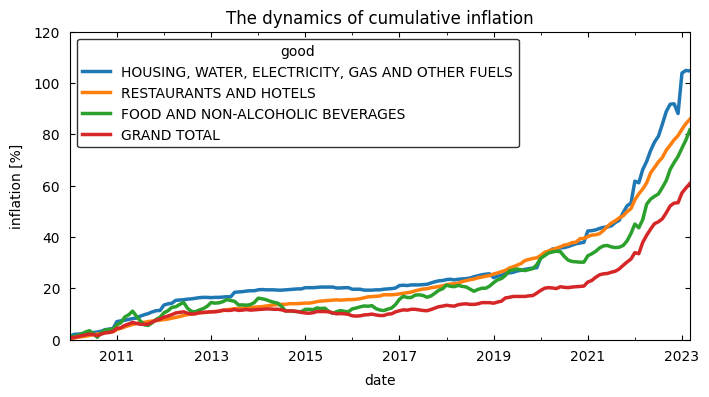

In [8]:
# set for clarity
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['xtick.major.pad'] = 7.0
plt.rcParams['ytick.major.pad'] = 7.0
plt.rcParams['axes.labelpad'] = 7.0

goods = infl_tot_last.index[:4]

infl_tot['inflation_cumul'].loc[:, goods].plot(
    title='The dynamics of cumulative inflation', ylabel='inflation [%]', 
    lw=2.5, ylim=(0, 120), figsize=(8, 4)
);

Focusing on the <font color=#ff7f0e>GRAND TOTAL</font> curve, in the first two years (2010 and 2011) we can observe a small increase in the prices. Then, within 2012-2016 the index remained quite stable. Beginning from 2017/2018, the cumulative inflation started to grow again, accelerating rapidly in 2021.

The results show how the prices evolved in relation to the base level from December 2009. To examine the changes on a different time scale, we can plot both year-to-year and month-to-month coefficients, uncovering possible peaks of increases or decreases in the data.

**Note**: The year-to-year curve begins in December 2010, since the earliest year comparison of the prices is possible between 2010-12 and 2009-12.

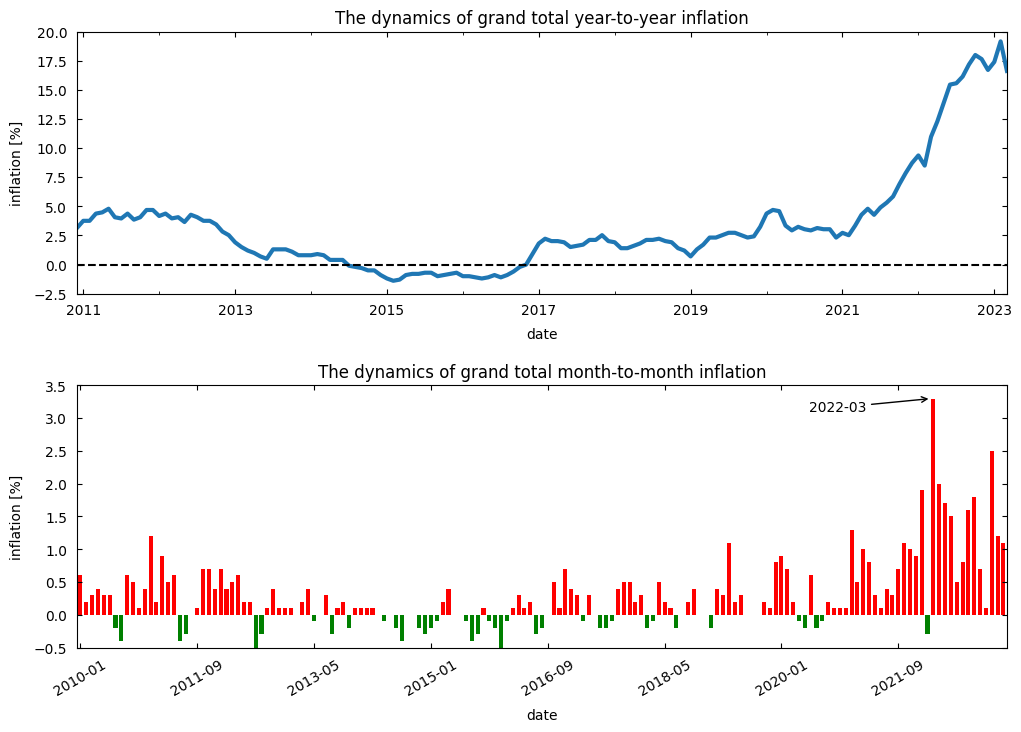

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.35)

# the y2y line plot
infl_tot['inflation_y2y'].loc[:, 'GRAND TOTAL'].plot(
    title='The dynamics of grand total year-to-year inflation', 
    ylabel='inflation [%]', 
    lw=3, ax=axes[0]
)
axes[0].axhline(y=0, linestyle='--', color='k')
axes[0].set_ylim(-2.5, 20.0)
axes[0].set_xlim(pd.Period('2010-12'))

infl_tot_GTm2m = infl_tot['inflation_m2m'].loc[:, 'GRAND TOTAL']

# the m2m bar plot
infl_tot_GTm2m.plot(
    kind='bar', 
    title='The dynamics of grand total month-to-month inflation', 
    ylabel='inflation [%]', 
    width=0.7, color=np.where(infl_tot_GTm2m > 0, 'r', 'g'), 
    ax=axes[1]
)
axes[1].set_ylim(-0.5, 3.5)
axes[1].xaxis.set_major_locator(plt.MaxNLocator('auto'))  # improve x-ticks
axes[1].xaxis.set_tick_params(rotation=30)

# annotate the peak for 2022-03
patch = axes[1].patches[12 * 12 + 3 - 1]
bar_xy = (patch.get_x(), patch.get_height())
bar_width = patch.get_width()

axes[1].annotate('2022-03', xy=bar_xy, 
    xytext=(bar_xy[0] - 30 * bar_width, bar_xy[1] - 0.2), 
    arrowprops={'arrowstyle': '->'}
);

The grand total year-to-year curve in the upper subplot shows, that before 2021, the inflation remained below 5%. We can also observe a short period of deflation, when the index was negative (the curve lying below 0% reference level, marked by horizontal dashed line). The monthly diagram (in the lower subplot) allows to track the increases (red) and decreases (green) more locally. As one can see, in the wast majority of months the prices increased, with the greatest peak observed in March 2022 (see the annotation in the subplot). The latter one can be correlated with the war on Ukraine, which started in the prior month.

The data frame presented below includes the values of the highest peaks (positive and negative) of month-to-month inflation among the main categories of goods, along with the date of the recorded extreme. The values are sorted by the highest positive peak (descending).

In [10]:
# the highest positive (peak_pos) and negative (peak_neg) peaks
infl_tot['inflation_m2m'].unstack().groupby(level='good')\
    .agg(date_peak_pos=lambda x: x.idxmax()[1], peak_pos='max', 
         date_peak_neg=lambda x: x.idxmin()[1], peak_neg='min')\
    .sort_values('peak_pos', ascending=False)

,date_peak_pos,peak_pos,date_peak_neg,peak_neg
good,,,,
TRANSPORT,2022-03,17.50,2022-08,-5.10
"HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS",2023-01,8.40,2022-12,-2.00
EDUCATION,2022-09,7.40,2013-09,-6.90
CLOTHING AND FOOTWEAR,2023-03,5.00,2020-01,-4.50
COMMUNICATIONS,2011-08,4.80,2013-11,-4.90
FOOD AND NON-ALCOHOLIC BEVERAGES,2022-04,4.10,2012-07,-2.00
GRAND TOTAL,2022-03,3.30,2012-07,-0.50
RECREATION AND CULTURE,2022-02,2.70,2015-09,-1.80
ALCOHOLIC BEVERAGES AND TOBACCO,2023-02,2.40,2017-04,-0.40


As one can see in the first row, the highest positive peak was noted in the <font color=#ff7f0e>TRANSPORT</font> category - the month-to-month inflation reached the extreme of 17.5% in March 2022, which can be also related to the Ukraine situation. The largest decline for the considered category was observed in August 2022, when the index decreased by 5.1%. Taking into account all the categories, most of the positive peaks (the **peak_pos** column) refer to 2022, when the problems with high inflation started.

The plots presented above can be reproduced for any of the categories available. For simplicity, in the further part of the notebook we will introduce appropriate function to do so easily.

So far we have been focused on the inflation dynamics regardless the households. Including the latter ones, we can see if there are any significant differences between them and get more detailed picture of the economic situation. As previously, we begin with the main categories of goods.

Let's first examine the final cumulative inflation (as of March 2023), split into households and goods.

In [11]:
# main categories of goods only
infl_main = infl_m.query(f'good.isin({goods_main})')

# the table of final cumulative inflation
infl_main.loc['2023-03'].pivot_table(
    index='household', columns='good', 
    values='inflation_cumul'
)

good,ALCOHOLIC BEVERAGES AND TOBACCO,CLOTHING AND FOOTWEAR,COMMUNICATIONS,EDUCATION,FOOD AND NON-ALCOHOLIC BEVERAGES,"FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE MAINTENANCE OF THE HOUSE",GRAND TOTAL,HEALTH,"HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS",MISCELLANEOUS GOODS AND SERVICES,RECREATION AND CULTURE,RESTAURANTS AND HOTELS,TRANSPORT
household,,,,,,,,,,,,,
GRAND TOTAL,58.08,-27.58,11.77,50.27,81.65,34.64,60.77,50.28,104.65,40.47,46.21,85.79,43.15
Households maintained from non-earned sources,70.80,-28.62,9.94,51.35,82.88,35.85,63.52,49.10,102.84,36.11,40.39,93.10,50.49
Households of employees,56.52,-28.05,9.87,49.15,81.33,34.78,58.40,53.36,103.11,41.45,45.48,84.14,41.34
Households of farmers,59.33,-27.75,12.27,43.83,81.91,34.10,61.24,47.62,123.25,37.68,35.16,82.85,51.48
Households of pensioners,75.76,-25.63,13.09,48.05,82.61,34.26,69.60,40.86,106.18,44.06,45.09,94.01,53.68
Households of retirees,70.62,-24.34,13.78,44.01,83.49,35.60,65.77,42.43,103.93,40.20,52.41,89.66,49.74
Households of the self-employed,52.36,-27.71,13.33,52.03,81.46,36.26,56.24,58.53,101.61,43.15,50.33,83.60,39.02


To determine the average change in price across all the households, we can calculate the mean and the standard deviation for different categories of goods.

**Note**: The obtained values of the mean can be different than the ones given in the <font color=#ff7f0e>GRAND TOTAL</font> row, since the households can contribute in the grand total aggregation with different weights; here, we calculate a simple arithmetic mean.

In [12]:
# calculate the mean and the standard deviation across all the households
infl_main[
    (infl_main.household != 'GRAND TOTAL') &
    (infl_main.index == '2023-03')
].groupby('good').inflation_cumul.agg(['mean', 'std'])\
    .sort_values('mean', ascending=False)

,mean,std
good,,
"HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS",106.82,8.19
RESTAURANTS AND HOTELS,87.89,5.01
FOOD AND NON-ALCOHOLIC BEVERAGES,82.28,0.85
ALCOHOLIC BEVERAGES AND TOBACCO,64.23,9.39
GRAND TOTAL,62.46,4.89
HEALTH,48.65,6.64
EDUCATION,48.07,3.52
TRANSPORT,47.62,5.96
RECREATION AND CULTURE,44.81,6.35


Different types of households have different statistical baskets of goods, which serve as the basis for the price evaluation and its change (e.g., younger employees can have more complex <font color=#ff7f0e>EDUCATIONAL</font> basket then the retirees, since the former ones are typically still developing their professional qualifications). The **std** column shown above reflects these differences in the terms of data dispersion.

The highest result for the considered dataset can be observed for <font color=#ff7f0e>HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS</font>, reaching the mean of 106.82% with the standard deviation of 8.19%. The high discrepancy can be easily explained, if we take a look at the cumulative inflation table above. The indices for almost all of the households reside around 100%-105%, excluding the <font color=#ff7f0e>households of farmers</font>, for which the increase equals 123.25% (an outlier in the data).

Since the energy costs increased radically in 2022, we can compare the year-to-year changes for the farmers with the average ones, examining if the phenomenon has been observed earlier.

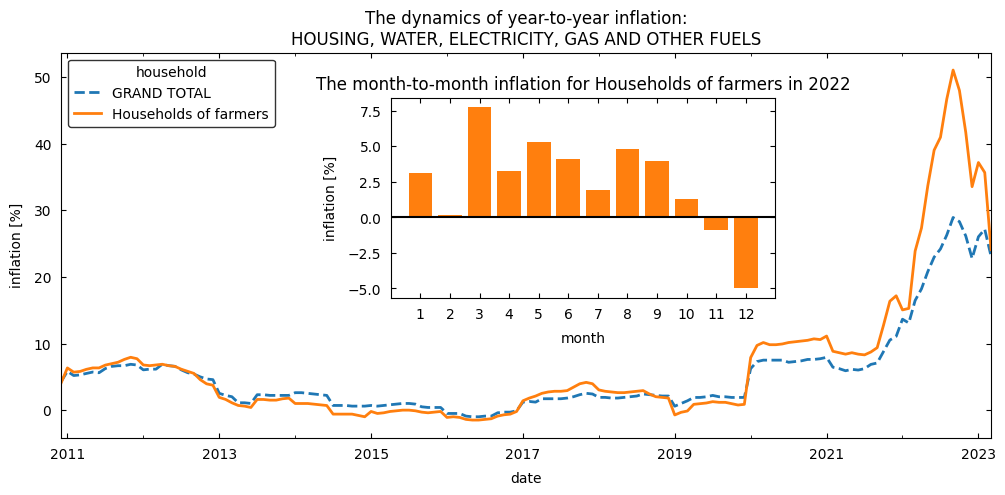

In [13]:
# categories to compare
hholds = ['GRAND TOTAL', 'Households of farmers']
good = 'HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS'

fig, axes = plt.subplots(figsize=(12, 5))

# plot the comparison (line plot)
infl_main[
    infl_main.household.isin(hholds) &
    (infl_main.good == good)
].pivot(columns='household', values='inflation_y2y').plot(
    title=f'The dynamics of year-to-year inflation:\n{good}', 
    ylabel='inflation [%]', 
    style=['--', '-'], lw=2, xlim=pd.Period('2010-12'), 
    ax=axes
)

# add the inbox of the monthly changes for farmers in 2022
inbox = fig.add_axes([0.4, 0.39, 0.32, 0.4])

x_in = np.arange(1, 13)
y_in = infl_main.query(f'household == "{hholds[1]}" and good == "{good}"')\
    .loc['2022'].inflation_m2m.values

inbox.bar(x_in, y_in, color='tab:orange')
inbox.axhline(y=0, linestyle='-', color='k')
inbox.set(title=f'The month-to-month inflation for {hholds[1]} in 2022', 
    xlabel='month', ylabel='inflation [%]')
inbox.xaxis.set_major_locator(plt.MultipleLocator(1))

As one can see, the indices remained similar for a long period of time. The cost of the energy basket for the farmers started to exceed the grand total level in 2020, spiking rapidly two years later. The decline around the ending period of March 2023 suggests, that the prices may begin to slowly stabilize (see also the inbox with the bar plot for month-to-month changes in 2022 only).

Another high discrepancy in the data can be observed for <font color=#ff7f0e>ALCOHOLIC BEVERAGES AND TOBACCO</font> (9.39%). In this case, we will compare the <font color=#ff7f0e>Households of employees</font> and the <font color=#ff7f0e>Households of retirees</font>, including also the <font color=#ff7f0e>GRAND TOTAL</font> result.

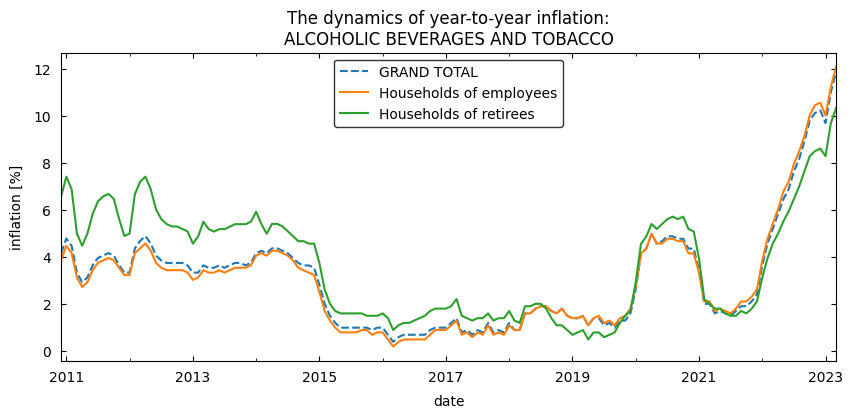

In [14]:
hholds = ['GRAND TOTAL', 'Households of employees', 'Households of retirees']
good = 'ALCOHOLIC BEVERAGES AND TOBACCO'

infl_main[
    infl_main.household.isin(hholds) &
    (infl_main.good == good)
].pivot(columns='household', values='inflation_y2y').plot(
    title=f'The dynamics of year-to-year inflation:\n{good}', 
    ylabel='inflation [%]', style=['--', '-', '-'], 
    xlim=pd.Period('2010-12'), figsize=(10, 4)
)

plt.legend(loc='upper center');

The evolution of the <font color=#ff7f0e>ALCOHOLIC BEVERAGES AND TOBACCO</font> index for the <font color=#ff7f0e>Households of employees</font> was very close to the average in the whole time interval. The prices for the <font color=#ff7f0e>Households of retirees</font> exceeded the mean before 2015, getting closer to it in further years. Beginning from 2022, one can observe that the index remains below the <font color=#ff7f0e>GRAND TOTAL</font> level.\
Interestingly, the standard deviation of 0.85% in the cumulative inflation of <font color=#ff7f0e>FOOD AND NON-ALCOHOLIC BEVERAGES</font> suggests, that the changes within these products occur among the households similarly, which can be easily shown by plotting the year-to-year diagrams.

To see the differences between the described categories, we can compare the monthly changes within them using bar plots and transparency. For the clarity of comparison, we limit the results to 2020-2023 period and the <font color=#ff7f0e>GRAND TOTAL</font> category only.

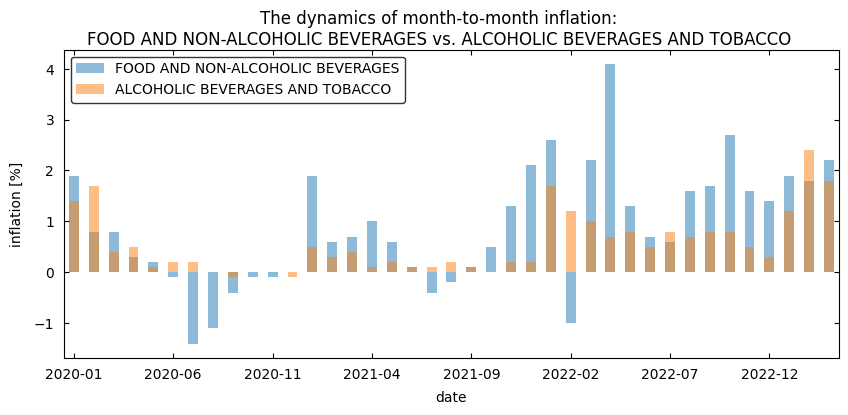

In [15]:
cats = ['FOOD AND NON-ALCOHOLIC BEVERAGES', 
        'ALCOHOLIC BEVERAGES AND TOBACCO']
cols = ['tab:blue', 'tab:orange']

fig, axes = plt.subplots(figsize=(10, 4))

# plot the categories
for (cat, col) in zip(cats, cols):
    infl_tot['2020':'2023']['inflation_m2m'][cat].plot(
        kind='bar', 
        color=col, alpha=0.5, 
        legend=True, ax=axes
    )

# improve the ticks
axes.xaxis.set_major_locator(plt.MaxNLocator('auto'))
axes.xaxis.set_tick_params(rotation=0)

plt.ylabel('inflation [%]')
plt.suptitle('The dynamics of month-to-month inflation:\n'
             f'{cats[0]} vs. {cats[1]}');

The differences in the inflation between chosen types of households can be easily expressed by aggregating the data. In the cell below we present the comparison involving the <font color=#ff7f0e>Households of employees</font> and the <font color=#ff7f0e>Households of retirees</font>, calculating the basic statistics (mean, standard deviation and maximum) of the absolute differences between the year-to-year indices, which are grouped using different types of the available goods. The results show, that the highest discrepancy can be observed within the <font color=#ff7f0e>EDUCATION</font> category, for which the indices between the considered households differ on average by 1.3%.

In [16]:
hholds = ['Households of employees', 'Households of retirees']

# calculate basic statistics for the absolute differences between households
infl_main[infl_main.household.isin(hholds)].reset_index().pivot(
    columns='household', 
    index=['date', 'good'], 
    values='inflation_y2y'
).dropna().diff(axis=1).abs().iloc[:, -1].groupby('good')\
.agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)

,mean,std,max
good,,,
EDUCATION,1.30,1.61,6.04
ALCOHOLIC BEVERAGES AND TOBACCO,1.11,0.73,2.94
RECREATION AND CULTURE,0.83,0.59,2.50
HEALTH,0.59,0.47,2.05
COMMUNICATIONS,0.57,0.50,2.61
TRANSPORT,0.50,0.44,2.49
CLOTHING AND FOOTWEAR,0.42,0.23,0.92
GRAND TOTAL,0.40,0.31,1.37
FOOD AND NON-ALCOHOLIC BEVERAGES,0.35,0.27,1.18


The analysis presented above can be performed for more detailed types of goods, which include both smaller categories of goods (like the <font color=#ff7f0e>Alcoholic beverages</font> one), as well as specific products (e.g., <font color=#ff7f0e>Bread</font>). A sample of the available identifiers is given below:

In [17]:
goods_n_main[:7]

['Alcoholic beverages',
 'Operation of personal transport equipment',
 'Actual rentals for housing',
 'Ripening and processed cheese',
 'Postal services',
 'Passenger transport by train',
 'Processed meat and other meat preparations']

Before we move into particular goods, we can examine which ones reached the highest cumulative score as of March 2023 (regardless the household type).

In [18]:
infl_n_main = infl_m.query(f'good.isin({goods_n_main})')

infl_n_main.query('household == "GRAND TOTAL"').loc['2023-03']\
    .nlargest(10, 'inflation_cumul')  # sort by the highest cumulative index

,household,good,inflation_m2m,inflation_y2y,inflation_cumul
date,,,,,
2023-03,GRAND TOTAL,Liquid and solid fuels,-4.40,40.53,192.99
2023-03,GRAND TOTAL,Bread,0.90,25.72,134.04
2023-03,GRAND TOTAL,Sugar,-0.70,81.73,128.49
2023-03,GRAND TOTAL,"Fresh, chilled or frozen seafood and fish",1.50,29.48,118.20
2023-03,GRAND TOTAL,Margarine and other vegetable fats,-0.10,44.08,114.02
2023-03,GRAND TOTAL,Vegetables,7.00,28.55,110.44
2023-03,GRAND TOTAL,Out-patient services,1.00,14.46,107.92
2023-03,GRAND TOTAL,Medical services,0.90,14.91,107.43
2023-03,GRAND TOTAL,Heat energy,1.40,40.60,106.49


The highest growth of <font color=#ff7f0e>Liquid and solid fuels</font> coincides with the results obtained previously for the <font color=#ff7f0e>HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS</font> category. Among the top positions, we can also indicate different types of food, with the highest increase in the price of <font color=#ff7f0e>Bread</font>, reaching 134.04% (compared to 2009-12).

To simplify the comparison of different categories, we define the `inflation_plot` function in the <a href='utils.py'>`utils.py`</a> module. The tool allows to visualize the dynamics of inflation by choosing one of the following scenarios:

* the inflation of one particular good for one chosen household type (includes all the inflation types),
* the comparison of the inflation of one chosen good between various households (cumulative and year-to-year indicators), or
* the comparison of the inflation of various good for one chosen household (also cumulative and year-to-year indicators).

We exclude the case 'many goods and many households' to avoid illegibility of the graphs. While operating with the function, one can provide only partial labels of the investigated good(s)/household(s) (the string case matters; to avoid ambiguity, the partial labels should be chosen carefully). The function parameters **categories** and **goods** can be given as strings or lists - in the case of both being lists, at least one of them has to be one-element (see the function details in <a href='utils.py'>`utils.py`</a>).

**Note**: The function allows to choose any time interval for the data. It should be noted, that when the starting date is later than 2010-01, the cumulative inflation is re-calculated in relation to the value for the first available date, which determines a new base level of the prices (one month prior). This way, one can see how the indices evolved within any chosen time interval.

**Note**: The function is also designed to work with the quarterly data, which is discussed in the further part of the notebook.

In the following cells, one can find three simple examples of possible comparisons for the available data. The starting date is chosen as Mar 2020, i.e., the month when the COVID-19 pandemic started in Poland (in this scenario, Feb 2020 becomes the prices new base level).

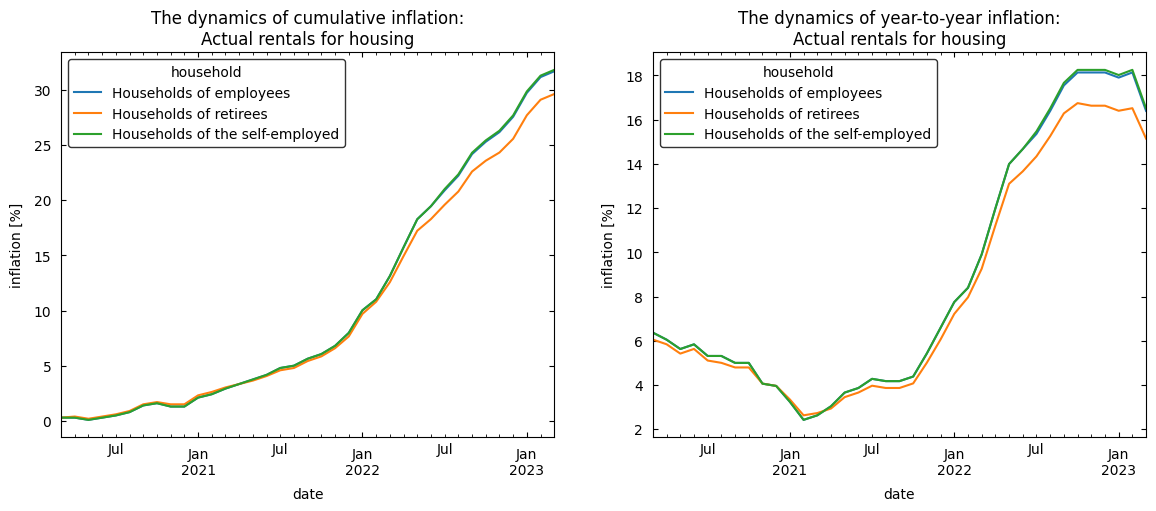

In [19]:
from functools import partial

from utils import inflation_plot

# create a partial version of the function for easier typing
infl_p_20_03 = partial(inflation_plot, infl_n_main, starttime='2020-03')

# compare households for fixed good
hh = ['employee', 'self', 'retire']
g = ['rentals']

infl_p_20_03(categories=hh, goods=g);

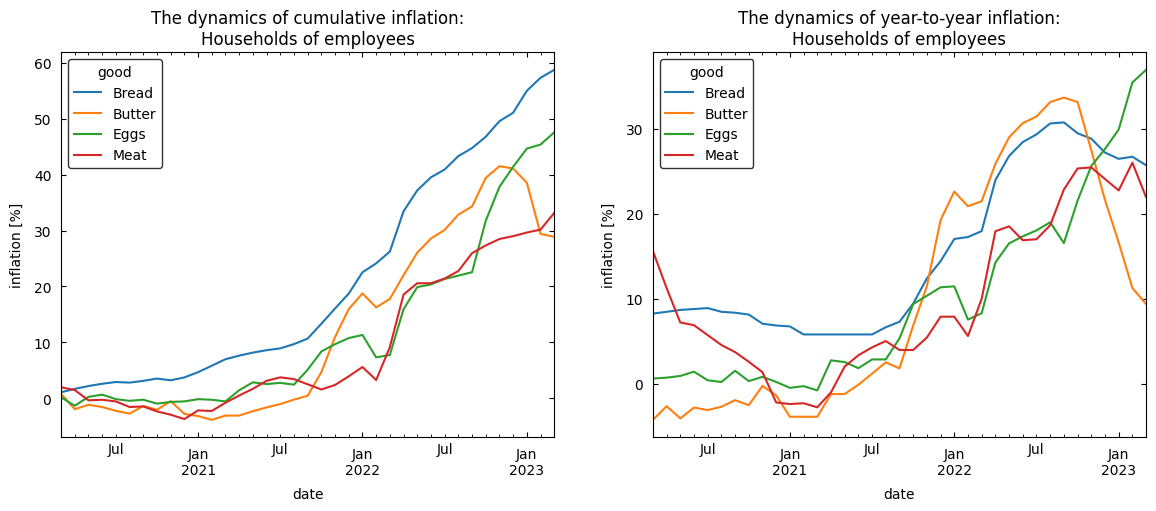

In [20]:
# compare goods for fixed household
hh = ['employee']
g = ['Bread', 'Butter', 'Meat', 'Eggs']

infl_p_20_03(categories=hh, goods=g);

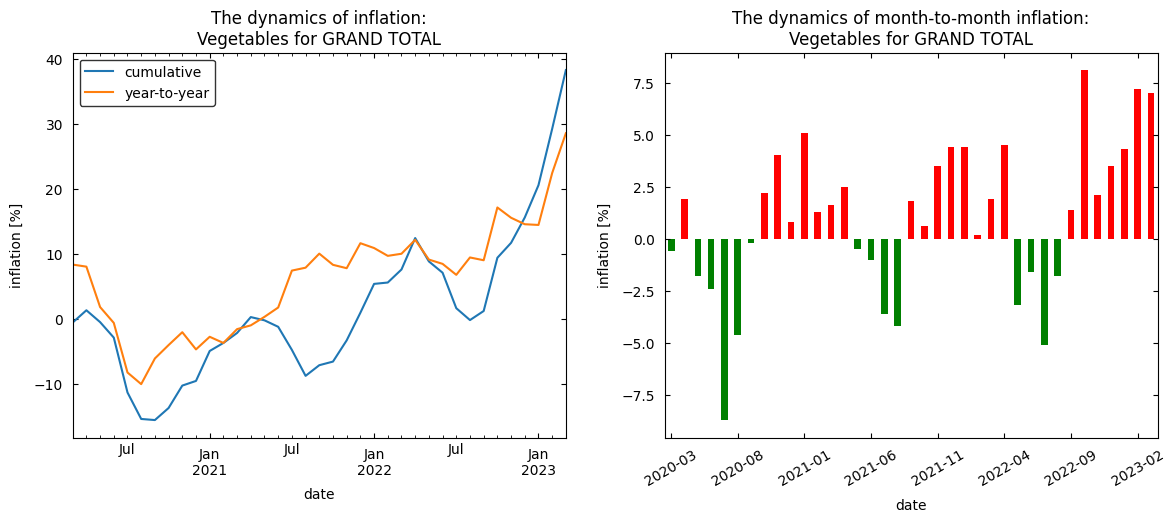

In [21]:
# show the dynamics for fixed household and good
hh = ['GRAND']
g = 'Veg'

infl_p_20_03(categories=hh, goods=g);

The last result shows how the prices of vegetables change in cycles, depending on the season of the year (see the declines in late spring and summer in the bar plot).

To investigate the relations between different types of goods, we can perform a simple correlation analysis along with the regression plots. We will use the `seaborn` package to do both.

Let's start from calculating the correlation coefficients between the available categories of goods, using the year-to-year indices and limiting the dates to 2011-2019 (we exclude the extreme event of the COVID-19 pandemic, which may influence the relations between different types of goods in unusual way).

**Note**: When calculating the correlation matrix we implicitly assume, that the relations between the goods haven't changed within the considered time frame. This is a *very strong assumption*, which may not be fully satisfied (e.g., due to the occurrence of some unusual events disrupting the relations).

In [22]:
# grab the data
infl_n_main_11_19 = infl_n_main.query('household == "GRAND TOTAL"').pivot(
     columns='good', 
     values='inflation_y2y'
).drop(columns='GRAND TOTAL').loc['2011':'2019']

# calculate the correlation matrix
infl_corr = infl_n_main_11_19.corr()

# filter for the highest results (corr >= 0.85)
high_corr = []
for (i, j), corr in np.ndenumerate(infl_corr):
    if j > i and abs(corr) >= 0.85:
        high_corr.append((infl_corr.index[i], infl_corr.columns[j], corr))

# build the frame with the highest scores
goods_corr = pd.DataFrame(high_corr, columns=['good_1', 'good_2', 'corr'])
goods_corr.sort_values('corr', ascending=False, ignore_index=True)

,good_1,good_2,corr
0,Fuels,Operation of personal transport equipment,1.00
1,"Medical products, appliances and equipment",Pharmaceutical products,1.00
2,Coffee,"Coffee, tea and cocoa",0.99
3,Fuels,Petrol,0.99
4,Operation of personal transport equipment,Petrol,0.99
5,Cheese and curd,Ripening and processed cheese,0.99
6,Diesel oil,Operation of personal transport equipment,0.99
7,Diesel oil,Fuels,0.99
8,Bread,Bread and cereals,0.99
9,Diesel oil,Petrol,0.97


We will focus only on the pairs of goods with the highest correlation (coefficient at least 0.85). As can be seen above, some of the categories are obviously correlated due to the partition of the goods (e.g., the <font color=#ff7f0e>Coffee</font> and the <font color=#ff7f0e>Coffee, tea and cocoa</font> categories with $\sigma=0.99$). On the other hand, some of the results might not be so straightforward, like the <font color=#ff7f0e>Beef</font> and the <font color=#ff7f0e>Non-alcoholic beverages</font> connection ($\sigma=0.93$).

Limiting the number of categories for clarity, we can easily plot the correlation matrix as follows:

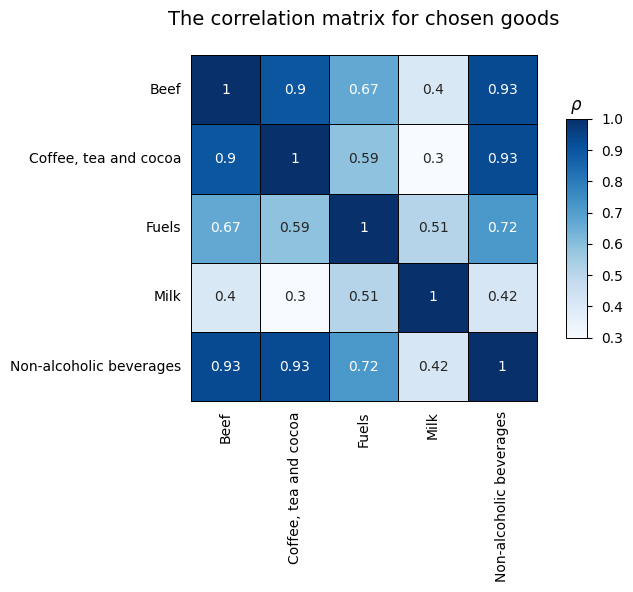

In [23]:
# select categories
corr_cats = ['Beef', 'Coffee, tea and cocoa', 'Non-alcoholic beverages', 
             'Milk', 'Fuels']

# grab appropriate part of the correlation matrix
for axis in [0, 1]:
    infl_corr = infl_corr.filter(items=corr_cats, axis=axis)\
        .sort_index(axis=axis)

# plot the correlation matrix
with plt.style.context({'ytick.right': False}):
    fig = plt.figure()
    gs = fig.add_gridspec(10, 20)
    hm = fig.add_subplot(gs[:, :14])  # for the matrix
    cb = fig.add_subplot(gs[2:8, 15:16])  # for the color bar
    
    sns.heatmap(
        data=infl_corr, 
        vmin=0.3, vmax=1.0,  # limit the lower border for readability
        annot=True, square=True, 
        linewidths=0.7, linecolor='k', clip_on=False, 
        cmap='Blues', 
        ax=hm, cbar_ax=cb
    )

# improve the heat map
hm.set(xlabel='', ylabel='')
hm.set_title('The correlation matrix for chosen goods\n', fontsize=14)
hm.tick_params(length=0)

# improve the color bar
cb.spines["outline"].set(lw=0.7, edgecolor="black")
cb.set_title(r'$\rho$')
cb.tick_params(direction='out')

The relations between chosen goods can be visualized using pair plots:

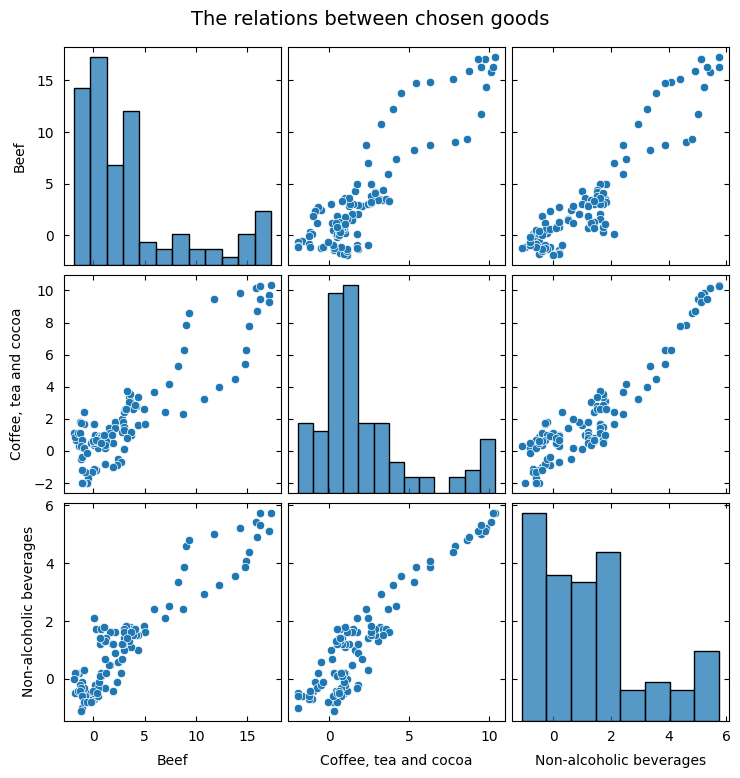

In [24]:
# plot pairs
pg = sns.pairplot(infl_n_main_11_19[corr_cats[:3]])

# improve the layout
for ax in pg.axes.flatten():
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(True)
        ax.tick_params(right=True)
    
plt.suptitle('The relations between chosen goods', y=1.03, fontsize=14);

As can be seen, the relation between the <font color=#ff7f0e>Coffee, tea and cocoa</font> and the <font color=#ff7f0e>Non-alcoholic beverages</font> categories is close to linear ($\sigma=0.93$). This can be easily explained, since coffee, tea and cocoa surely *are* non-alcoholic beverages, so they participate in shaping the inflation of the latter ones (among other possible beverages). However, even though the correlation between the <font color=#ff7f0e>Beef</font> and the <font color=#ff7f0e>Non-alcoholic beverages</font> is (approximately) at the same 0.93 level, the relation is more complex and not as linear as in the previous case.

When investigating correlations between datasets, we should carefully study the distribution of the data, since the coefficient itself may be misleading (see, e.g., [here](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) for the famous Anscombe's quartet). The problem with our data lies also in the fact, that the majority of the results is accumulated around the lower boundary (inflation below 5%), where the relations may not be simply linear.

We finish this section with plotting the regression of <font color=#ff7f0e>Diesel oil</font> and <font color=#ff7f0e>Petrol</font>, which shows that the inflation indices between these two are almost perfectly linearly matched.

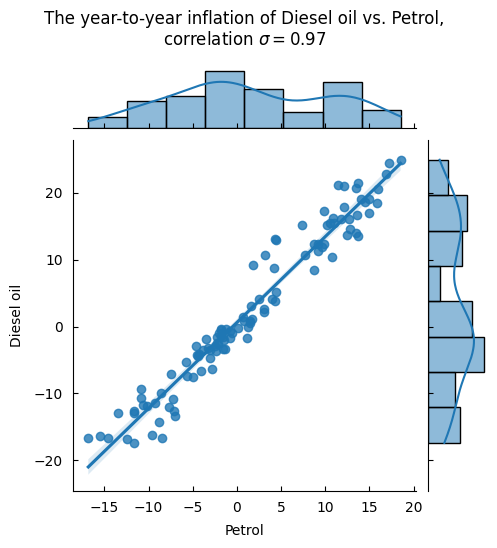

In [25]:
diesel_petrol_corr = infl_n_main_11_19['Diesel oil'].corr(
    infl_n_main_11_19['Petrol'])

with plt.style.context({'ytick.right': False, 'xtick.top': False}):
    sns.jointplot(
        data=infl_n_main_11_19, 
        y='Diesel oil', x='Petrol', 
        kind='reg', 
        height=5
    )

plt.title('The year-to-year inflation of Diesel oil vs. Petrol,\n'
          fr'correlation $\sigma=${diesel_petrol_corr:.2f}', y=1.25);

### The quarterly inflation <a id='quarterly_infl'></a>

In this section we investigate the quarterly inflation dataset, which has been queried from the `inflation_quarterly` table using the <a href='inflation_database.db'>`inflation_database.db`</a> database (see the top of the notebook for details). The sample of the data is given below.

In [26]:
infl_q.sample(5, random_state=0)

,voivodeship,good,inflation
date,,,
2010Q4,OPOLSKIE,TRANSPORT,100.90
2018Q3,SWIETOKRZYSKIE,"FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE M...",100.70
2013Q1,POMORSKIE,RECREATION AND CULTURE,101.00
2022Q1,MAZOWIECKIE,RECREATION AND CULTURE,104.00
2020Q2,WARMINSKO-MAZURSKIE,RECREATION AND CULTURE,100.20


The data uncover how the inflation changed quarterly (within the [2010-Q1, 2022-Q3] interval), in relation to two attributes:

* the goods, which include only the main categories of goods/services (see also the previous, monthly section), and
* the voivodeships, which determine the main administrative division of Poland (into 16 regions).

The voivodeships can be used to compare the inflation between different parts of the country, similarly to the comparison involving the households for the monthly data. Both columns (**good** and **voivodeship**) include also a general summary, i.e., the <font color=#ff7f0e>GRAND TOTAL</font> label for goods and the <font color=#ff7f0e>POLAND</font> label for voivodeships. More details on the dataset can be found in the <a href="0-data_cleaning.ipynb">0-data_cleaning.ipynb</a> notebook, where it has been cleaned.

As with the previously considered data, we can use the quarterly values to calculate the year-to-year and cumulative indices. The year-to-year index will refer to the price from the same quarter one year ago, while the cumulative one to the price levels from 2009-Q4. To make the process more compact, we define the `calculate_indices` function in the <a href='utils.py'>`utils.py`</a> module.

In [27]:
from utils import calculate_indices

infl_q = calculate_indices(infl_q, ['voivodeship', 'good'], base_tf='q2q')

infl_q.sample(5, random_state=0)

,voivodeship,good,inflation_q2q,inflation_y2y,inflation_cumul
date,,,,,
2019Q3,PODKARPACKIE,TRANSPORT,-1.80,-0.53,11.97
2017Q2,PODKARPACKIE,RECREATION AND CULTURE,0.50,1.60,7.02
2021Q1,OPOLSKIE,CLOTHING AND FOOTWEAR,-5.60,-3.50,-44.10
2020Q4,ZACHODNIOPOMORSKIE,TRANSPORT,1.90,-4.34,3.71
2021Q2,ZACHODNIOPOMORSKIE,TRANSPORT,5.70,16.25,15.65


Before we start the analysis, let's compare the monthly and the quarterly indices to see if they match. To do so, we can estimate the quarter-to-quarter inflation using the month-to-month data (in the most general case, i.e., regardless the type of good, household or voivodeship). We will assume, that the average price within a given quarter is a simple mean of the prices from the corresponding three months, which are approximated using m2m indices. Since we calculate the rate of change, the absolute value of price is redundant.

**Note**: Since the granularity and the methodology of collecting the data are different between the monthly and the quarterly datasets, the obtained comparison should indicate similarities, but not perfect matching. To evaluate the differences, we add the absolute error column to the data frame (the absolute difference between the estimated inflation indicator and the original one).


In [28]:
"""
What is happening below (line by line): 
- grab the m2m column from the 'monthly inflation' dataset, 
- transform the values into rates (from percentages), 
- resample the data into quarters and grab the coefficients of the 
  price change (in relation to the month preceding the quarter), 
- prepare the window calculation involving two consecutive quarters, 
- aggregate the values by calculating the q2q change, 
- transform the values into percentages (from rates) 
- rename the obtained series for clarity
"""
infl_q_change = infl_m[(infl_m.household == 'GRAND TOTAL') & 
    (infl_m.good == 'GRAND TOTAL')].inflation_m2m\
    .add(100.0).div(100.0)\
    .resample('3M').transform(lambda x: [x[0], x[:2].prod(), x[:3].prod()])\
    .shift(1).rolling(window=6, step=3)\
    .agg(lambda x: sum(x[3:]) * x[2] / sum(x[:3])).iloc[2:]\
    .mul(100.0).sub(100.0)\
    .rename('estimated_Q_inf')

# correct the index
infl_q_change.index = infl_q_change.index - pd.offsets.MonthEnd(1)
infl_q_change = infl_q_change.asfreq('Q')

# grab the original quarterly inflation
infl_q_tot = infl_q[(infl_q.voivodeship == 'POLAND') & 
    (infl_q.good == 'GRAND TOTAL')].inflation_q2q\
    .rename('original_Q_inf')

from IPython.display import display

# change the display precision for easier comparison and show the final frame
with pd.option_context('display.float_format', lambda x: '%.5f' % x):
    comparison = pd.merge(infl_q_tot, infl_q_change, how = 'left', 
        left_index=True, right_index=True).assign(
        abs_err=lambda x: abs(x.estimated_Q_inf - x.original_Q_inf)
    )
    display(comparison.head(10))

,original_Q_inf,estimated_Q_inf,abs_err
date,,,
2010Q1,0.90000,NaN,NaN
2010Q2,1.00000,0.96981,0.03019
2010Q3,0.00000,0.03157,0.03157
2010Q4,0.90000,0.96824,0.06824
2011Q1,2.10000,1.94372,0.15628
2011Q2,1.50000,1.43728,0.06272
2011Q3,-0.40000,-0.33467,0.06533
2011Q4,1.30000,1.37265,0.07265
2012Q1,1.70000,1.64158,0.05842


As one can see, the estimations and the original values are quite compatible. The differences may be effected by the calculation methodology (here, we estimate the quarterly price as a simple mean of the prices resulting from the available monthly inflation) and values precision (the original monthly data is approximated only to one decimal point; when the values are transformed - multiplied/subdivided, the precision can play a major role in the final result).

The quarterly data allow us to compare the inflation between different regions of Poland, both in the general case (the <font color=#ff7f0e>GRAND TOTAL</font> category), as well as for chosen types of goods/services.

We can start from examining the cumulative index across the voivodeships, determining the top regions, where the prices increased the most (in relation to 2009-Q4 level).

In [29]:
infl_q.query('good == "GRAND TOTAL"').loc['2022-Q3']\
    .drop(infl_q.columns[1:4], axis=1)\
    .sort_values('inflation_cumul', ascending=False)

,voivodeship,inflation_cumul
date,,
2022Q3,MALOPOLSKIE,52.57
2022Q3,WIELKOPOLSKIE,51.49
2022Q3,LODZKIE,51.13
2022Q3,SWIETOKRZYSKIE,50.90
2022Q3,KUJAWSKO-POMORSKIE,50.52
2022Q3,OPOLSKIE,49.65
2022Q3,LUBUSKIE,48.91
2022Q3,WARMINSKO-MAZURSKIE,48.26
2022Q3,POLAND,47.25


As can be seen, the difference between the highest and the lowest result reaches almost 10%, with the average cumulative inflation for the whole country around 47.25% (the <font color=#ff7f0e>POLAND</font> label). The MAZOWIECKIE voivodeship (where the country capital Warsaw is located) can be found with the second lowest total increase.

To examine the highest quarter-to-quarter increases, we can compute a simple cross tabulation using the voivodeships (rows) and the goods (columns). The result obtained for each pair indicates the date(s), when the highest quarter-to-quarter change has been observed, along with its value. The tool function `highest_q2q` (included below) examines possible ties, when the same record was reached in more than one quarter.

In [30]:
# add the column of (date, q2q inflation) tuples
infl_q_date_q2q = infl_q.assign(
    date_q2q=pd.Series(infl_q.inflation_q2q.items())\
        .transform(lambda x: (x[0], round(x[1], 1))).values
)

# a simple function to examine possible ties in the sorted series
def highest_q2q(series):
    highest = []  # the list of the highest q2q value with date(s)
    highest.append(series[0][0])  # save the first date
    max_q2q = series[0][1]  # save the highest q2q value for comparison
    for date, rec in series[1:]:
        if rec == max_q2q:
            highest.append(date)
        else:
            break
    highest.append(max_q2q)  # save the highest q2q value
    return tuple(highest)

# build the crosstab
pd.crosstab(
    index=infl_q_date_q2q.voivodeship, 
    columns=infl_q_date_q2q.good, 
    values=infl_q_date_q2q.date_q2q, 
    # sort and determine the highest q2q index with corresponding date(s)
    aggfunc=lambda x: x.sort_values(key=lambda y: y.apply(lambda z: z[1]),
        ascending=False).pipe(highest_q2q)
)

good,ALCOHOLIC BEVERAGES AND TOBACCO,CLOTHING AND FOOTWEAR,EDUCATION,FOOD AND NON-ALCOHOLIC BEVERAGES,"FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE MAINTENANCE OF THE HOUSE",GRAND TOTAL,HEALTH,"HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS",RECREATION AND CULTURE,TRANSPORT
voivodeship,,,,,,,,,,
DOLNOSLASKIE,"(2020Q1, 2.8)","(2022Q2, 5.0)","(2011Q4, 3.9)","(2022Q2, 6.6)","(2022Q2, 3.5)","(2022Q2, 5.5)","(2022Q2, 2.8)","(2022Q1, 8.1)","(2022Q1, 3.9)","(2022Q2, 13.1)"
KUJAWSKO-POMORSKIE,"(2022Q1, 3.2)","(2019Q4, 6.8)","(2019Q4, 4.8)","(2022Q2, 6.5)","(2022Q2, 3.7)","(2022Q2, 6.6)","(2022Q2, 3.0)","(2022Q2, 9.6)","(2022Q3, 4.0)","(2022Q2, 14.6)"
LODZKIE,"(2022Q1, 3.3)","(2021Q4, 6.5)","(2020Q4, 6.3)","(2022Q2, 6.6)","(2022Q2, 4.1)","(2022Q2, 6.3)","(2020Q2, 2.8)","(2022Q3, 9.0)","(2022Q3, 4.8)","(2022Q2, 15.3)"
LUBELSKIE,"(2022Q1, 3.6)","(2013Q4, 4.8)","(2010Q4, 3.2)","(2022Q2, 7.1)","(2022Q2, 3.0)","(2022Q2, 6.3)","(2022Q2, 3.1)","(2022Q2, 2022Q1, 8.7)","(2022Q3, 5.7)","(2022Q2, 12.9)"
LUBUSKIE,"(2022Q2, 3.0)","(2021Q4, 5.3)","(2011Q4, 3.6)","(2022Q2, 6.9)","(2022Q2, 4.0)","(2022Q2, 5.5)","(2022Q2, 3.7)","(2022Q1, 8.5)","(2022Q3, 4.0)","(2022Q2, 14.3)"
MALOPOLSKIE,"(2022Q1, 3.2)","(2022Q2, 4.8)","(2021Q4, 4.2)","(2022Q2, 6.3)","(2022Q2, 4.1)","(2022Q2, 5.6)","(2022Q2, 2.9)","(2022Q3, 2022Q1, 7.4)","(2022Q3, 4.8)","(2022Q2, 15.5)"
MAZOWIECKIE,"(2022Q1, 3.2)","(2022Q2, 2021Q2, 5.7)","(2011Q4, 4.3)","(2022Q2, 6.2)","(2022Q2, 3.4)","(2022Q2, 5.3)","(2022Q2, 3.2)","(2022Q1, 6.9)","(2022Q3, 4.4)","(2022Q2, 14.1)"
OPOLSKIE,"(2022Q2, 2020Q1, 2.7)","(2022Q2, 6.9)","(2020Q4, 5.5)","(2022Q2, 5.8)","(2022Q2, 4.1)","(2022Q2, 5.9)","(2022Q1, 3.9)","(2022Q3, 12.2)","(2022Q3, 4.3)","(2022Q2, 13.8)"
PODKARPACKIE,"(2022Q1, 3.2)","(2021Q4, 4.1)","(2011Q4, 5.6)","(2022Q2, 5.7)","(2022Q2, 3.2)","(2022Q2, 4.9)","(2022Q2, 3.0)","(2022Q1, 7.5)","(2022Q3, 4.0)","(2022Q2, 16.3)"


The frame presented above allows to indicate the goods, which increased the most in the same quarter, regardless the voivodeship (e.g., the **FOOD AND NON-ALCOHOLIC BEVERAGES** column with 2022-Q2 quarter only). However, some of the highest growths refer to different periods of time, depending on the region (see, e.g., the **EDUCATION** column, with references to various years; for **WARMINSKO-MAZURSKIE** region (the row), the record of 3.3% has been observed in both 2022-Q3 and 2020-Q3). The **GRAND TOTAL** indicator for all of the voivodeships noted the highest increase in 2022-Q2, with the average of 5.8% (the result for the **POLAND** row).

Transforming slightly the code above, we can indicate which voivodeship(s) reached the highest quarter-to-quarter inflation for chosen quarter. The results are presented in the data frame below, with the dates denoted in the index, and the categories given as column headers. The frame acknowledges for the possibility of ties, which is more probable than in the previous scenario.

In [31]:
# add the column of (voivodeship, q2q inflation) tuples
infl_q_voiv_q2q = infl_q[infl_q.voivodeship != 'POLAND'].assign(
    date_q2q=lambda x: pd.Series(x.set_index(x.voivodeship).inflation_q2q\
        .items()).transform(lambda y: (y[0], round(y[1], 1))).values
)

# build the crosstab
infl_q_voiv_q2q_max = pd.crosstab(
    index=infl_q_voiv_q2q.index, 
    columns=infl_q_voiv_q2q.good, 
    values=infl_q_voiv_q2q.date_q2q, 
    # determine the highest q2q index with corresponding voivodeship(s)
    aggfunc=lambda x: x.sort_values(key=lambda y: y.apply(lambda z: z[1]),
        ascending=False).pipe(highest_q2q), 
    rownames=['date']
)

# extend column width for readability
with pd.option_context('display.max_colwidth', None):
    display(infl_q_voiv_q2q_max.head())

good,ALCOHOLIC BEVERAGES AND TOBACCO,CLOTHING AND FOOTWEAR,EDUCATION,FOOD AND NON-ALCOHOLIC BEVERAGES,"FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE MAINTENANCE OF THE HOUSE",GRAND TOTAL,HEALTH,"HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS",RECREATION AND CULTURE,TRANSPORT
date,,,,,,,,,,
2010Q1,"(PODKARPACKIE, 1.5)","(PODKARPACKIE, -1.9)","(PODKARPACKIE, 1.1)","(MAZOWIECKIE, LODZKIE, 2.1)","(PODLASKIE, LUBUSKIE, KUJAWSKO-POMORSKIE, 0.6)","(WARMINSKO-MAZURSKIE, 1.2)","(SWIETOKRZYSKIE, 1.4)","(WARMINSKO-MAZURSKIE, 3.1)","(PODKARPACKIE, 0.6)","(OPOLSKIE, 2.2)"
2010Q2,"(WIELKOPOLSKIE, 2.3)","(PODKARPACKIE, 0.9)","(KUJAWSKO-POMORSKIE, LUBELSKIE, 0.5)","(DOLNOSLASKIE, 2.2)","(DOLNOSLASKIE, PODKARPACKIE, 0.6)","(DOLNOSLASKIE, 1.3)","(POMORSKIE, WARMINSKO-MAZURSKIE, 1.3)","(ZACHODNIOPOMORSKIE, 1.2)","(DOLNOSLASKIE, 1.2)","(LUBUSKIE, 4.5)"
2010Q3,"(ZACHODNIOPOMORSKIE, 0.6)","(PODKARPACKIE, -0.7)","(WIELKOPOLSKIE, 2.6)","(PODKARPACKIE, 0.0)","(SWIETOKRZYSKIE, PODKARPACKIE, KUJAWSKO-POMORSKIE, 0.4)","(PODKARPACKIE, 0.3)","(PODKARPACKIE, 1.1)","(SWIETOKRZYSKIE, 1.2)","(LUBUSKIE, 1.9)","(LUBELSKIE, 0.5)"
2010Q4,"(KUJAWSKO-POMORSKIE, WIELKOPOLSKIE, 1.3)","(OPOLSKIE, 3.5)","(MAZOWIECKIE, PODLASKIE, WARMINSKO-MAZURSKIE, LUBELSKIE, 3.2)","(MALOPOLSKIE, 2.4)","(SWIETOKRZYSKIE, 0.6)","(SWIETOKRZYSKIE, 1.5)","(PODKARPACKIE, 1.2)","(SWIETOKRZYSKIE, 1.7)","(ZACHODNIOPOMORSKIE, 0.3)","(SWIETOKRZYSKIE, PODKARPACKIE, 1.3)"
2011Q1,"(ZACHODNIOPOMORSKIE, 1.8)","(WARMINSKO-MAZURSKIE, PODKARPACKIE, -2.6)","(POMORSKIE, 1.2)","(MALOPOLSKIE, WARMINSKO-MAZURSKIE, 4.2)","(DOLNOSLASKIE, PODLASKIE, 1.5)","(WARMINSKO-MAZURSKIE, 2.4)","(LUBUSKIE, 2.0)","(KUJAWSKO-POMORSKIE, 4.0)","(LUBELSKIE, 1.3)","(WIELKOPOLSKIE, 4.7)"


To determine which voivodeships noted the inflation records most often, we will rank the above data frame, calculating the number of occurrences of each voivodeship (i.e., how many times it reached the highest quarter-to-quarter inflation in relation to others). The result is limited to the <font color=#ff7f0e>GRAND TOTAL</font> case only (the average inflation rate across all the goods/services), but can be easily reproduced for any chosen category.

In [32]:
voiv_rec = infl_q_voiv_q2q_max['GRAND TOTAL'].apply(lambda x: x[:-1])

pd.Series([voiv for rec in voiv_rec for voiv in rec]).value_counts()

LUBUSKIE               12
SWIETOKRZYSKIE         10
MALOPOLSKIE             8
WARMINSKO-MAZURSKIE     7
ZACHODNIOPOMORSKIE      7
OPOLSKIE                7
DOLNOSLASKIE            6
KUJAWSKO-POMORSKIE      5
POMORSKIE               5
LODZKIE                 5
PODKARPACKIE            4
MAZOWIECKIE             4
WIELKOPOLSKIE           4
PODLASKIE               4
LUBELSKIE               1
SLASKIE                 1
dtype: int64

The results show, that <font color=#ff7f0e>LUBUSKIE</font> voivodeship noted the quarter-to-quarter inflation records most often, i.e., 12 times in the considered [2010-Q1, 2022-Q3] time interval. On the other hand, <font color=#ff7f0e>SLASKIE</font> region has reached the highest result only once, as well as the <font color=#ff7f0e>LUBELSKIE</font> one.

**Note**: The LUBUSKIE and LUBELSKIE voivodeships are completely different regions, although they are spelled very similarly.

To visualize the comparison between the voivodeships or the dynamics of inflation in one of them, we can use the `inflation_plot` function defined previously for the monthly data. In the next two cells we present the evolution of inflation of selected goods in <font color=#ff7f0e>MAZOWIECKIE</font> voivodeship, as well as the comparison between <font color=#ff7f0e>LUBUSKIE</font> and <font color=#ff7f0e>SLASKIE</font> regions for the <font color=#ff7f0e>GRAND TOTAL</font> case. In both scenarios, the base level for the cumulative index has been chosen as 2013-Q4.

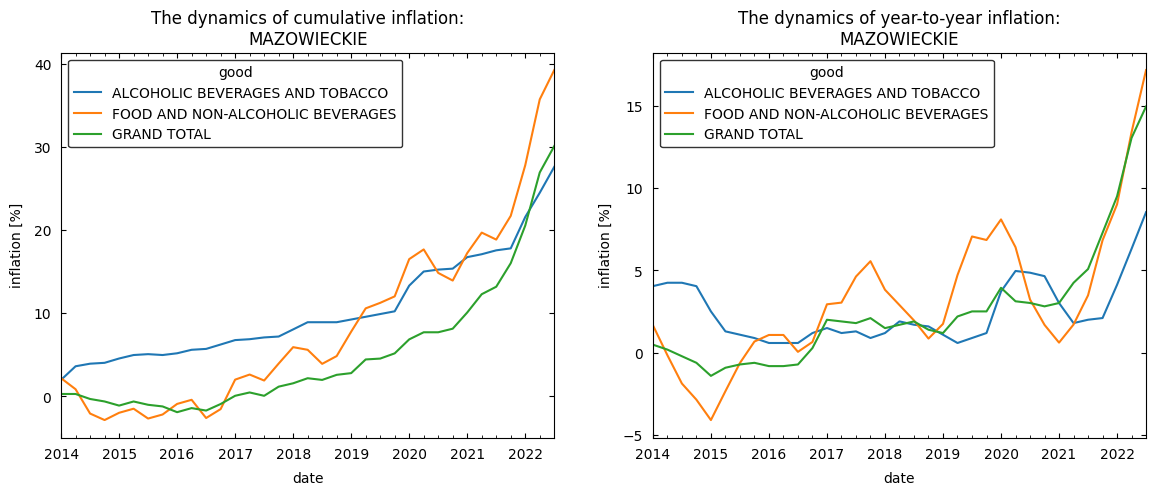

In [33]:
# compare goods for fixed voivodeship
voiv = ['MAZOWIECKIE']
g = ['GRAND', 'FOOD', 'ALCO']

inflation_plot(infl_q, '2014-Q1', categories=voiv, goods=g, quarterly=True);

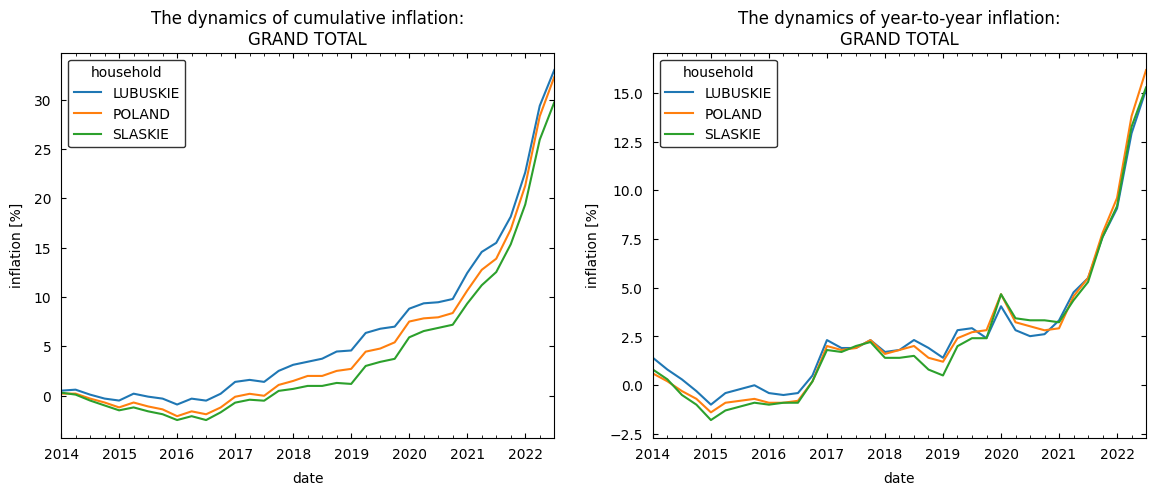

In [34]:
# compare voivodeships within the 'GRAND TOTAL' case
voiv = ['POLAND', 'LUBUSKIE', 'SLASKIE']

inflation_plot(infl_q, '2014-Q1', categories=voiv, quarterly=True);

As we can see, the cumulative inflation in <font color=#ff7f0e>SLASKIE</font> remained below the average (<font color=#ff7f0e>POLAND</font>) within the whole time interval, in contrast to <font color=#ff7f0e>LUBUSKIE</font> voivodeship, which has been always above. The year-to-year scenario indicates more similarities between the regions. Using the `inflation_plot` function, one can also visualize the dynamics of particular category of good in any chosen voivodeship (returns the bar plot; see also ['The monthly inflation'](#monthly_infl) section for details).

The comparison presented above allows to see how the inflation changed over time for chosen voivodeships of Poland. If we are interested only in specific date (quarter), we can visualize the results in a more readable way with the country map, observing how the index varied geographically. To do so, we will use the `geopandas` package for processing geospatial data.

Without getting too much into details, we need the geospatial data of Poland, which can be downloaded using the following [Geoportal](https://www.geoportal.gov.pl/dane/panstwowy-rejestr-granic) (the direct links to the data are available only in the Polish version of the portal; see the bottom in the webpage for the downloads table). All the necessary files that we need for voivodeships are already stored in the <a href='voivodeships_map_data'>`voivodeships_map_data`</a> catalogue.

At first, we need to load the data and correct the Polish accents for compatibility with the `infl_q` data frame. We will handle this using the `voivs_gdf` function from the <a href='utils.py'>`utils.py`</a> module.

In [35]:
from utils import voivs_gdf

voiv_map_gdf = voivs_gdf()

voiv_map_gdf.head()

,voivodeship,geometry
0,WIELKOPOLSKIE,"POLYGON ((18.14065 52.50609, 18.14115 52.50605..."
1,LODZKIE,"POLYGON ((20.42486 51.61167, 20.42489 51.61162..."
2,WARMINSKO-MAZURSKIE,"POLYGON ((20.29152 54.40384, 20.30025 54.40322..."
3,MALOPOLSKIE,"POLYGON ((20.80878 49.35366, 20.80898 49.35375..."
4,SWIETOKRZYSKIE,"POLYGON ((19.83803 50.59001, 19.83874 50.59033..."


The geopandas data frame (geo data frame) contains the geometry of each voivodeship (see the last column above) and allows to draw their borders in the map. To include the inflation data, we need to merge both frames using the voivodeships labels (the rows corresponding to the <font color=#ff7f0e>POLAND</font> one are excluded using the `dropna` function below).

In [36]:
infl_q_gdf = voiv_map_gdf.merge(infl_q.reset_index(), how='right', 
    on='voivodeship').set_index('date').dropna(subset='geometry')

Having the frames merged, we can plot the map using the `inflation_map` function, which has been defined in the <a href='utils.py'>`utils.py`</a> module. Using the tool, we need to determine the inflation type, the good and the quarter for comparison (parameters `inf_type`, `good` and `quarter`, respectively; see also the default values in the function definition). The resulting map allows to see how the inflation varied across different regions of the country.

**Note**: The variant of *cumulative* inflation type shows the index in reference to the fixed period of 2009-Q4. The function can be easily transformed if a different base level is required.

In the cell below, one can find two examples of the quarterly inflation in 2022-Q1, limited to the category of <font color=#ff7f0e>FOOD AND NON-ALCOHOLIC BEVERAGES</font> and the <font color=#ff7f0e>GRAND TOTAL</font> case.

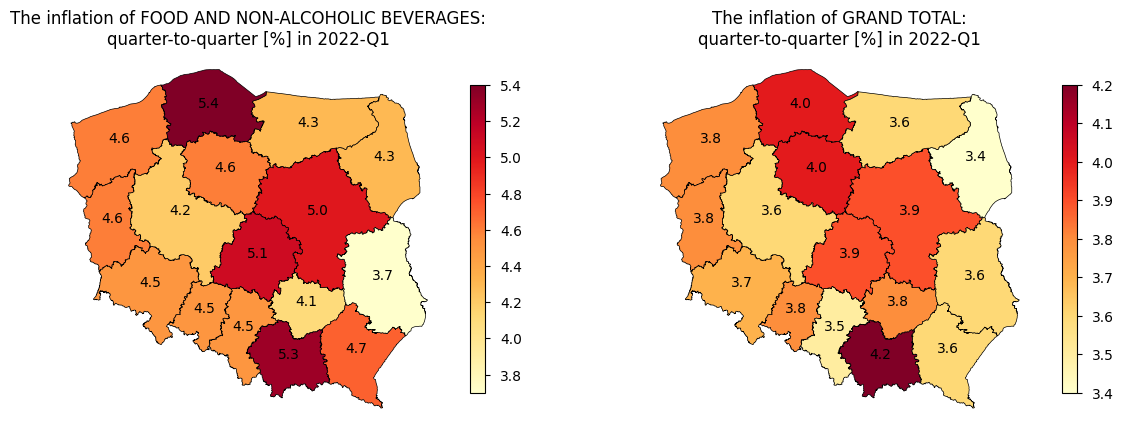

In [37]:
from utils import inflation_map

fig, axes = plt.subplots(1, 2, figsize=(14, 10))

inflation_map(infl_q_gdf, quarter='2022-Q1', good='FOOD', ax=axes[0])
inflation_map(infl_q_gdf, quarter='2022-Q1', good='GRAND', ax=axes[1]);

The results presented above confirm, that some of the regions can have similar inflation rates (e.g., the South-West border with 4.5% score within the <font color=#ff7f0e>FOOD AND NON-ALCOHOLIC BEVERAGES</font> category), while the others can differ (like <font color=#ff7f0e>LUBELSKIE</font> - 3.7% and <font color=#ff7f0e>POMORSKIE</font> - 5.4% regions). Although the observations refer to only one particular quarter, it is reasonable to assume, that various regions can exhibit some similarities, e.g., due to their geopolitical position.

To investigate the relations between the inflation in different voivodeships, we can begin from comparing the box plots for the quarter-to-quarter data (the originally available granularity). The examples for chosen voivodeships and goods are given as follows:

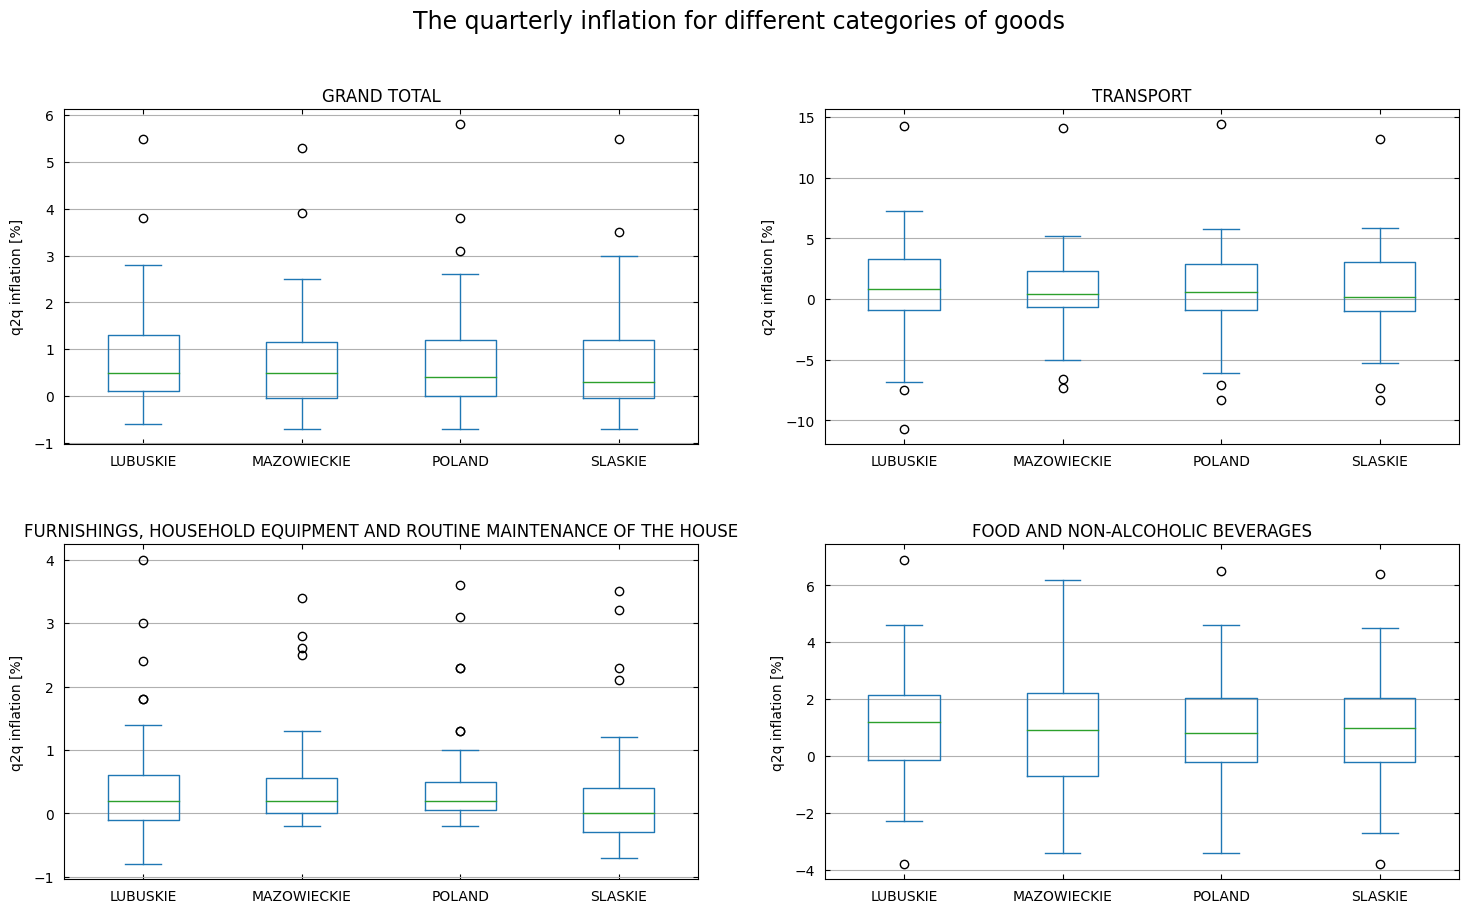

In [38]:
from utils import label_shorthands  # designed for easier selection of labels

# select voivodeships and goods
voivs = ['POLAND', 'LUBUSKIE', 'SLASKIE', 'MAZOWIECKIE']
goods = label_shorthands(infl_q, 
    ['GRAND', 'TRANSPORT', 'FURNISHINGS', 'FOOD'], 'good')

# prepare the data
infl_q_box  = infl_q[infl_q.voivodeship.isin(voivs)].pivot(
    columns=['good', 'voivodeship'], 
    values='inflation_q2q'
).sort_index(axis=1)

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.subplots_adjust(wspace=0.2, hspace=0.3)

# create the box plots
for ax, good in zip(axes.flatten(), goods):
    infl_q_box[good].plot(kind='box', title=good, 
        ylabel='q2q inflation [%]', ax=ax)
    ax.grid(axis='y')

plt.suptitle('The quarterly inflation for different categories of goods', 
    fontsize=17);

The box plots allow us to compare the quartiles between the voivodeships (including the whole country - see the <font color=#ff7f0e>POLAND</font> label), as well as the variability of data (the box whiskers) and possible outliers.

The results for the <font color=#ff7f0e>GRAND TOTAL</font> inflation seem similar, but one can indicate some differences within particular categories (see, e.g., <font color=#ff7f0e>LUBUSKIE</font> and <font color=#ff7f0e>MAZOWIECKIE</font> regions for the <font color=#ff7f0e>FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE MAINTENANCE OF THE HOUSE</font> category). Instead of plots, we can also grab the basic statistics in the form of data frame, comparing the inflation across the goods for chosen region (or vice-verse). The general case of <font color=#ff7f0e>POLAND</font> and such comparison can be found below.

In [39]:
infl_q.query('voivodeship == "POLAND"').groupby('good')\
    .inflation_q2q.describe().T

good,ALCOHOLIC BEVERAGES AND TOBACCO,CLOTHING AND FOOTWEAR,EDUCATION,FOOD AND NON-ALCOHOLIC BEVERAGES,"FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE MAINTENANCE OF THE HOUSE",GRAND TOTAL,HEALTH,"HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS",RECREATION AND CULTURE,TRANSPORT
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00
mean,0.75,-0.68,0.63,0.96,0.45,0.77,0.69,1.22,0.59,0.81
std,0.76,3.88,1.15,1.92,0.79,1.21,0.81,1.75,1.27,3.55
min,-0.10,-5.70,-4.20,-3.40,-0.20,-0.70,-1.90,-0.70,-2.00,-8.30
25%,0.30,-4.75,0.15,-0.20,0.05,0.00,0.35,0.25,-0.20,-0.90
50%,0.50,-1.60,0.50,0.80,0.20,0.40,0.70,0.70,0.60,0.60
75%,1.15,2.70,1.05,2.05,0.50,1.20,1.00,1.30,1.25,2.90
max,3.10,5.30,2.90,6.50,3.60,5.80,3.10,7.70,4.30,14.40


The box plot and basic statistics uncover how the inflation varied in time for chosen region and good. However, we are more interested in the differences between the voivodeships within every quarter, i.e., we want to answer the question: '*Do the inflation indices for two particular regions of Poland change statistically the same, or not?*' To find the solution, we can adopt simple hypothesis testing based on the available data.

Let $X$ denote the difference between the quarter-to-quarter inflation indices for two chosen voivodeships. If the prices change similarly in the regions, then the expected value $\mu = EX = 0$. The latter will be our null hypothesis:
$$H_0: \mu  = 0,$$
which can be opposed to an alternative:
$$H_1: \mu  \neq 0.$$

**Note**: If $H_1$ is true, then the dynamics of inflation is different between the voivodeships. However, if $H_0$ is true, then we can only state, that the distributions of the random variables describing the indices in the regions have the same expected value; the distributions themselves <u>can be different</u>! Investigating the hypotheses given above, we are rather interested in determining the regions, for which the differences are statistically significant (i.e., there is a strong evidence against $H_0$).

Let $X_1 = x_1, \ldots, X_n = x_n$ denote the data points of the observed differences.

**Note**: We assume, that $X_1, \ldots, X_n$ variables are independent and identically distributed (IID). Even though the inflation noted higher than usual values in recent years, the relations between the regions may be sustained (if the prices change similarly in chosen voivodeships, their increases should not effect the differences of the indices).

To estimate the expected value of the random variable $X$, we can use classical sample mean estimator:

$$\overline{X}_n = \frac{X_1 + \ldots + X_n}{n},$$

which asymptotically converges to the normal distribution (see the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) for details). In order to investigate the null hypothesis, we will apply the [Wald test](https://en.wikipedia.org/wiki/Wald_test), and calculate the p-value for each pair of voivodeships, within chosen good category.

The p-value is the probability of observing the test statistic (here, the Wald one) equal to or even more extreme than what was actually observed for the sample data, *assuming that the null hypothesis is true*. A small p-value suggests, that the observance is very unlikely, providing an argument against $H_0$ (the smaller the p-value is, the stronger the evidence). It should be noted, that the value <u>does not</u> evaluate the probability of the null hypothesis being true, i.e., a large p-value gives no evidence against the null, but doesn't necessarily mean, that the hypothesis is true.

Below we present the matrix of p-values for the <font color=#ff7f0e>GRAND TOTAL</font> category of goods, using the `voiv_hypothesis` function from the <a href='utils.py'>`utils.py`</a> module. The tool requires to provide a pivoted data frame, where the columns correspond to goods and voivodeships (MultiIndex). The records in the upper triangular part and the diagonal of the matrix are denoted as NaNs for clarity (each pair of the voivodeships appears twice, while the diagonal includes the pairing of the region with itself).

In [40]:
# get the pivoted data frame
infl_q_null = infl_q[(infl_q.voivodeship != 'POLAND')].pivot(
    columns=['good', 'voivodeship'], 
    values='inflation_q2q'
)

from utils import voivs_hypothesis

# calculate and show the p-values matrix
p_matrix_GT = voivs_hypothesis(infl_q_null, good='GRAND TOTAL')
with pd.option_context('display.float_format', lambda x: '%.3g' % x):
    display(p_matrix_GT)

,DOLNOSLASKIE,KUJAWSKO-POMORSKIE,LODZKIE,LUBELSKIE,LUBUSKIE,MALOPOLSKIE,MAZOWIECKIE,OPOLSKIE,PODKARPACKIE,PODLASKIE,POMORSKIE,SLASKIE,SWIETOKRZYSKIE,WARMINSKO-MAZURSKIE,WIELKOPOLSKIE,ZACHODNIOPOMORSKIE
DOLNOSLASKIE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KUJAWSKO-POMORSKIE,0.0738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LODZKIE,0.0306,0.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LUBELSKIE,0.929,0.0104,0.0203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LUBUSKIE,0.0514,0.582,0.491,0.232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MALOPOLSKIE,0.00394,0.466,0.644,0.00424,0.167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAZOWIECKIE,0.54,0.0306,0.0115,0.589,0.0129,0.00283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OPOLSKIE,0.153,0.769,0.604,0.0971,0.822,0.264,0.138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PODKARPACKIE,0.622,0.182,0.127,0.735,0.3,0.0151,0.322,0.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PODLASKIE,0.961,0.0439,0.0358,0.86,0.172,0.00977,0.705,0.153,0.689,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To reject or retain the null hypothesis, one have to set the cut-off $\alpha$ value, typically as $\alpha = 0.05$ or $\alpha = 0.01$. If the obtained p-value is less than $\alpha$, we can reject the $H_0$; otherwise, we retain it, since the evidence against is insufficient. In this context, rejecting the null hypothesis only when the p-value is less than $\alpha$ limits the type I error rate (the probability of incorrectly rejecting the null, when it is true) to be at most equal to $\alpha$.

For our analysis, we will use two levels of confidence, i.e., $\alpha = 0.05\ (5\%)$ and $\alpha = 0.005 \ (0.5\%)$, which can be referred to a strong and a very strong evidence against the null hypothesis, respectively.

The results presented above uncover, that for some pairs of voivodeships, it is very unlikely that the inflation changes similarly (e.g., for <font color=#ff7f0e>DOLNOSLASKIE</font> and <font color=#ff7f0e>MALOPOLSKIE</font> regions, for which p-value equals 0.00394). To indicate the pairs of possible significant differences, we can label them using the classification described above.

In [41]:
# stack the data frame and transform the index for clarity
p_rej_ret = p_matrix_GT.stack()
p_rej_ret.index = [' & '.join(pair) for pair in p_rej_ret.index]

# determine the rejection pairs
pd.cut(p_rej_ret, bins=[0, 0.005, 0.05, 1], 
    labels=['very strong against H_0', 'strong against H_0', 'retain'])\
    .loc[lambda x : x != 'retain'].sort_index().sort_values(kind='stable')

MALOPOLSKIE & DOLNOSLASKIE            very strong against H_0
MALOPOLSKIE & LUBELSKIE               very strong against H_0
MAZOWIECKIE & MALOPOLSKIE             very strong against H_0
SLASKIE & LODZKIE                     very strong against H_0
SLASKIE & MALOPOLSKIE                 very strong against H_0
WIELKOPOLSKIE & DOLNOSLASKIE          very strong against H_0
WIELKOPOLSKIE & LUBELSKIE             very strong against H_0
WIELKOPOLSKIE & MAZOWIECKIE           very strong against H_0
WIELKOPOLSKIE & PODLASKIE             very strong against H_0
WIELKOPOLSKIE & SLASKIE               very strong against H_0
ZACHODNIOPOMORSKIE & MALOPOLSKIE      very strong against H_0
LODZKIE & DOLNOSLASKIE                     strong against H_0
LUBELSKIE & KUJAWSKO-POMORSKIE             strong against H_0
LUBELSKIE & LODZKIE                        strong against H_0
MAZOWIECKIE & KUJAWSKO-POMORSKIE           strong against H_0
MAZOWIECKIE & LODZKIE                      strong against H_0
MAZOWIEC

The list enclosed above includes the pairs of voivodeships, for which the differences in inflation rates are statistically significant (according to our rejection cut-off levels). Applying the `sns.heatmap` function, one can make the result more readable, as shown below for the p-value matrices and chosen types of goods. For each pair of voivodeships, the red square corresponds to a very strong evidence against the null hypothesis (p-value below 0.005), while the yellow one to a strong evidence against the null (p-value greater than 0.005, but below 0.05). The cells left blank correspond to pairs, for which the $H_0$ cannot be rejected (p-value above 0.05 threshold).

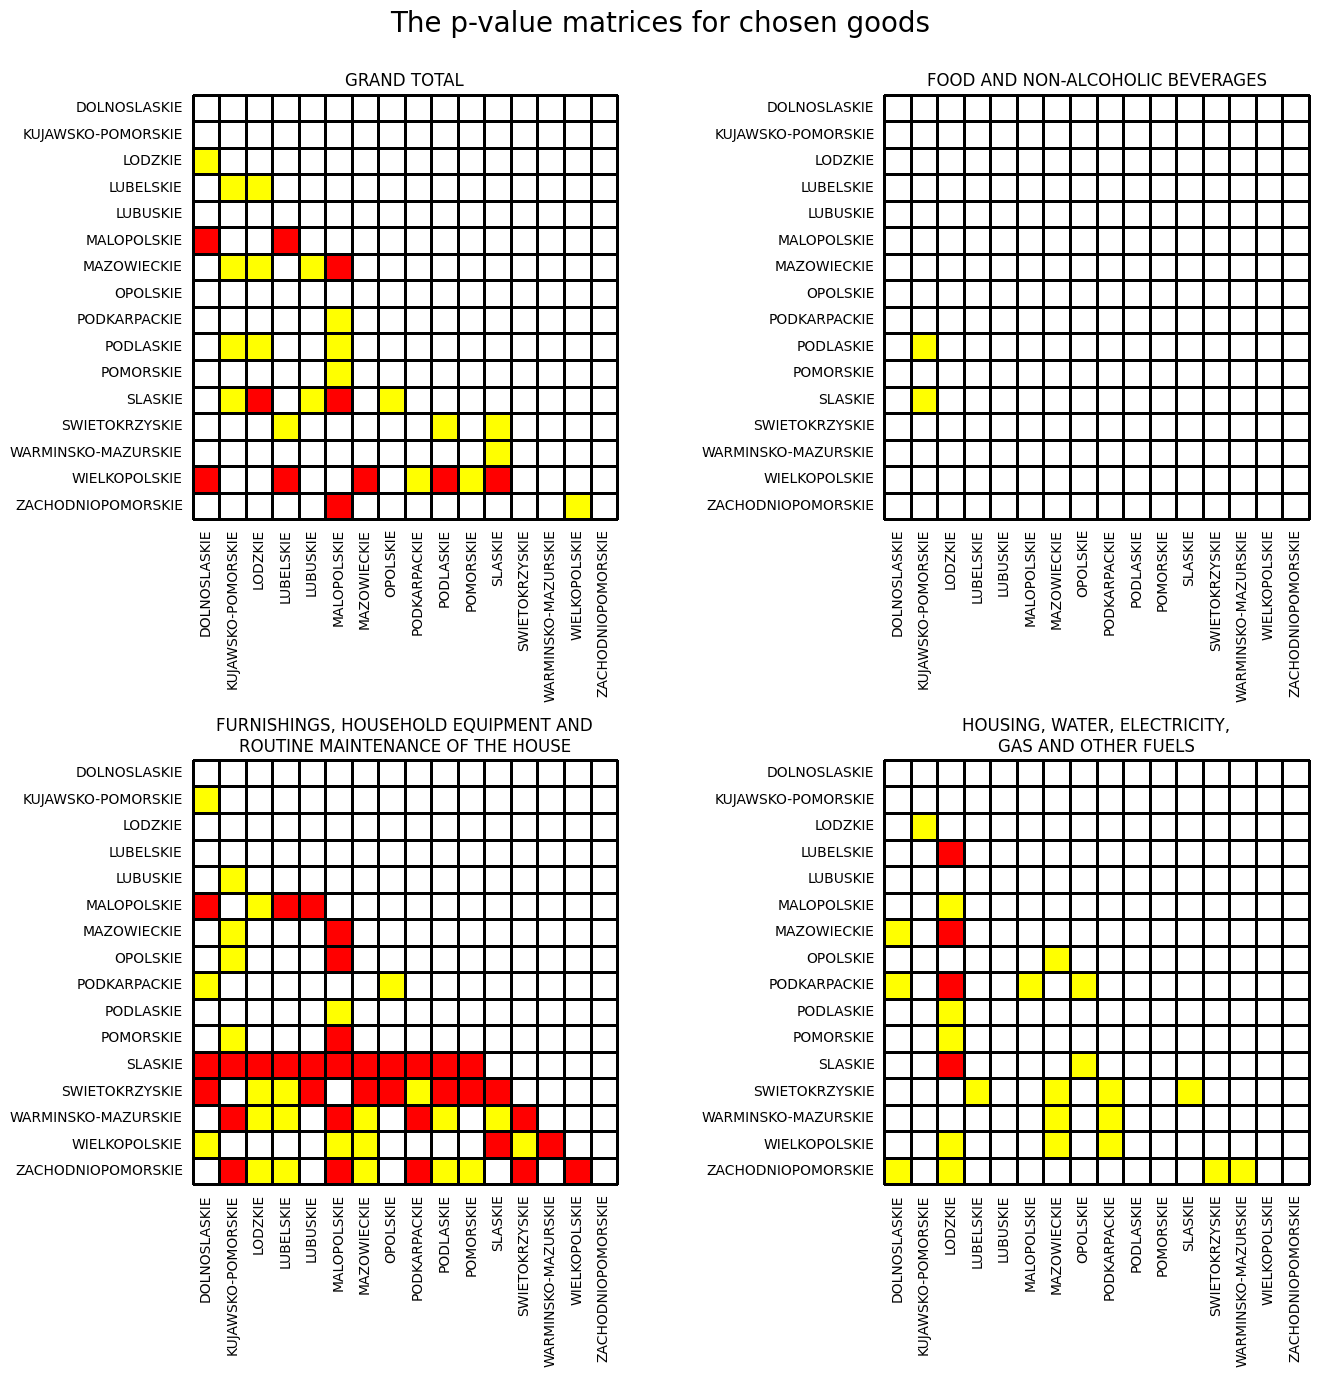

In [42]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# set color code
cmap = ListedColormap(['red', 'yellow', 'white'])
norm = BoundaryNorm([0, 0.005, 0.05, 1], cmap.N)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# select the goods
goods = label_shorthands(infl_q,
    ['GRAND', 'FOOD', 'FURNISHINGS', 'HOUSING'], 'good')

# a simple tool to break long labels into two lines (for clarity)
def label_break(label):
    break_index = label.index(' ', round(len(label) / 2))
    return label[:break_index] + '\n' + label[break_index + 1:]

# plot the matrices
for ax, good in zip(axes.flatten(), goods):
    p_matrix = voivs_hypothesis(infl_q_null, good=good)
    sns.heatmap(
        p_matrix.replace(np.nan, 1), 
        linewidths=1.0, linecolor='k', clip_on=False, 
        cmap=cmap, norm=norm, 
        square=True, cbar=False, ax=ax
    )
    ax.set_title(good if len(good) < 40 else label_break(good))
    ax.tick_params(length=0)

fig.suptitle('The p-value matrices for chosen goods\n', fontsize=20)
fig.tight_layout()

As one can see, the results vary, depending on the considered type of good/service. For the <font color=#ff7f0e>FOOD AND NON-ALCOHOLIC BEVERAGES</font> category, only two null hypotheses can be rejected with strong evidence against, as marked by two yellow cells. In the cases of <font color=#ff7f0e>FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE MAINTENANCE OF THE HOUSE</font> and <font color=#ff7f0e>HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS</font>, more rejection pairs occur, both with strong and very strong evidences against $H_0$. Interestingly, for the <font color=#ff7f0e>FURNISHINGS et al.</font> group one can see, that <font color=#ff7f0e>SLASKIE</font> voivodeship differs significantly from almost every other region (except the <font color=#ff7f0e>ZACHODNIOPOMORSKIE</font> one).

We can approximate the distribution of the inflation differences between the voivodeships (random variable $X$), using both histograms and KDEs. In the cell below, one can find the examples for two pairs of regions within the <font color=#ff7f0e>GRAND TOTAL</font> category: (left) <font color=#ff7f0e>MALOPOLSKIE</font> and <font color=#ff7f0e>DOLNOSLASKIE</font> with p-value around 0.00394 (very strong evidence for rejecting $H_0$), and (right) <font color=#ff7f0e>OPOLSKIE</font> and <font color=#ff7f0e>DOLNOSLASKIE</font> with p-value at 0.153 (no evidence against the null hypothesis). The histograms have been scaled for compatibility with the KDEs.

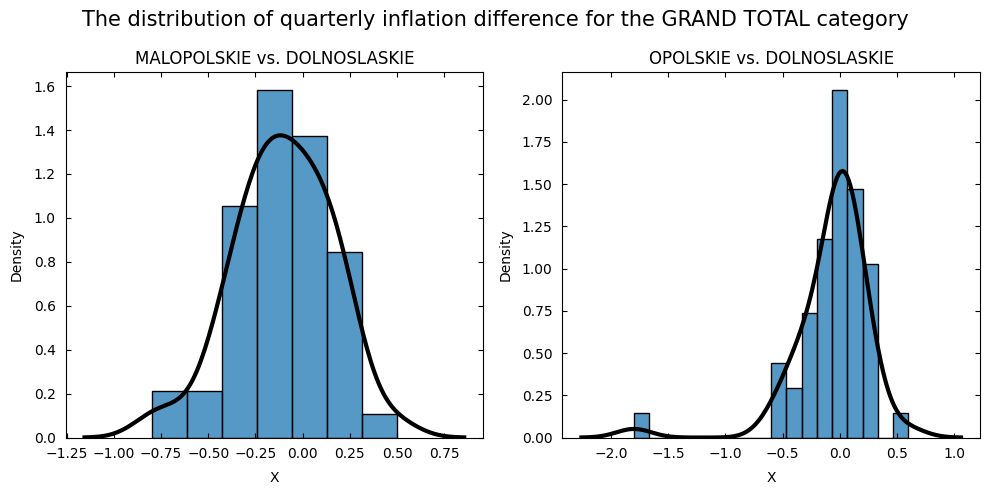

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# select voivodeships pairs
voiv_pairs = [['MALOPOLSKIE', 'DOLNOSLASKIE'], ['OPOLSKIE', 'DOLNOSLASKIE']]

# produce histograms and KDEs
for ax, pair in zip(axes, voiv_pairs):
    pair_diff = infl_q_null['GRAND TOTAL'][pair].diff(axis=1).iloc[:, 1]
    sns.histplot(pair_diff, stat='density', ax=ax)
    sns.kdeplot(pair_diff, ax=ax, linewidth=3, color='k')
    ax.set_title(f'{pair[0]} vs. {pair[1]}')
    ax.set_xlabel('X')

fig.suptitle('The distribution of quarterly inflation difference '
    'for the GRAND TOTAL category', fontsize=15)
fig.tight_layout()

The LHS of the figure confirms the result obtained from the hypothesis test, i.e., the inflation between the voivodeships indeed differs - the density function is asymmetric and shifted towards negative values, providing a strong evidence against $EX = 0$. On the other hand, the KDE for <font color=#ff7f0e>OPOLSKIE</font> vs. <font color=#ff7f0e>DOLNOSLASKIE</font> regions (the RHS of the figure) is almost perfectly symmetrical around $X=0$, with only a single outlier around $X=-1.75$. The result suggests, that the inflation in these two regions may change similarly (on average), and based on the density function shape, the difference distribution can be even close to the normal one.

**Note**: We should take into account, that the hypothesis testing performed above is in fact a *multiple testing* problem, i.e., we investigate many (multiple) null hypotheses, one for each pair of voivodeships. Consequently, it is likely that the test statistic might get into the rejection region just by chance (since we perform many trials), even though the null hypothesis is in fact true. Because of this, the decision on rejecting particular hypothesis should be also supported with other available tools (e.g., the histograms and KDEs presented above), limiting the probability of possible mistake.\
The problem of multiple testing can be handled with several methods, but the topic is beyond the scope of this project.

In the next notebook - <a href="2-wages_analysis.ipynb">2-wages_analysis.ipynb</a>, we investigate the dynamics of wages in the enterprise sector and compare the results with the inflation data.